# `Laboratorio 6 | Machine Learning`
* Marco Ferraro | B82957
* Roy Padilla | B85854

Descarga del dataset

In [1]:
import torchvision


GEN_LR = 3e-1
CLASSIFIER_LR = 5e-1

GEN_MOMENTUM = 2e-1
GEN_INPUT_DIM = 350

GAN_EPOCH = 150
EPOCH = 100

FILE_PATH = 'data/'


# Descarga del set de datos
train = torchvision.datasets.MNIST(".", download=True)

# Extracción de datos
x = train.data.float()
y = train.targets

Clase para manejar el dataset

In [2]:
import torch

class Dset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

Pruebas de mostrado de imágenes

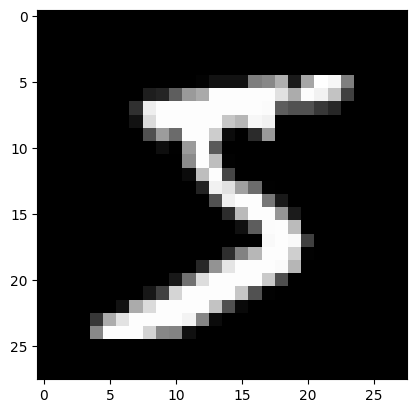

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from torch import flatten

def plot_image(img,save=False,name=None):
    cmap = 'gray' if img.shape[0]==1 else None
    data = (img.detach()*(255 if img.max()<=1 else 1)).permute((1,2,0)).numpy().astype(np.uint8)
    plt.figure()
    plt.imshow(data,cmap=cmap)
    plt.show()
    if save:
        if img.shape[0]==1:
            plt.imsave(name, data.squeeze(), cmap=cmap)
        else:
            plt.imsave(name, data, cmap=cmap)

img_number = 0
img = x[img_number]
plot_image( img[None, :], True, FILE_PATH + '{}.png'.format(img_number))

Filtrado de las imágenes


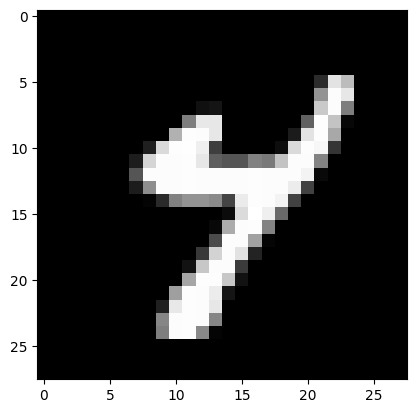

In [4]:
from torch import nonzero



target_number = 4

indeces = y == target_number

x_true = x[nonzero(indeces)]

img_number = 1863
img = x_true[img_number]
plot_image( img, True, FILE_PATH + '{}.png'.format(img_number))


`Clase Classifier`: 
Se va a encarga de determinar si una imagen es o no perteneciente a un dígito en específico o no

In [5]:
from torch import nn, flatten, tensor, cat, device, ones, zeros
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

DEVICE = device("cuda:0")

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()



        # self.n_input = 784
        # self.main = nn.Sequential(
        #       nn.Linear(self.n_input, 1024),
        #       nn.LeakyReLU(0.2),
        #       nn.Dropout(0.3),
        #       nn.Linear(1024, 512),
        #       nn.LeakyReLU(0.2),
        #       nn.Dropout(0.3),
        #       nn.Linear(512, 256),
        #       nn.LeakyReLU(0.2),
        #       nn.Dropout(0.3),
        #       nn.Linear(256, 1),
        #       nn.Sigmoid(),
        # )
        # Primera convolución
        # Entra una imagen 1x28x28
        self.conv1 =  nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = (5,5), stride = 1, padding = 'same')
        # # Sale una imagen de 4x28x28
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        # # img de 4x14x14 => 784

        # # # Entra una imagen 4x14x14 => 784
        self.conv2 =  nn.Conv2d(in_channels = 4, out_channels = 10, kernel_size = (3,3), stride = 1, padding = 'same')
        # # # Sale una imagen de 10x14x14
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)

        # # img de 10x7x7 => 490
        # # Red neuronal
        self.fc1 = nn.Linear(490, 800)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(800, 1) # Salida de si es el dígito o no => 1 = Verdadera | 0 = Falso
        self.act2 = nn.Sigmoid()

        # # Dropout (opcional)
        self.dropout = nn.Dropout(p = 0.2)
    
    def forward(self, x):
        ''' 
            Sobre-escritura del método de forward propagation, aplicando las capas convolucionales
            y luego las capas densas de la red neuronal
        '''
        # x = x.view(-1, 784)
        # return self.main(x)
        # # Aplicación de las convoluciones
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = flatten(x, 1)

        # # Capas densas
        x = self.act1(self.fc1(x))
        out = self.act2(self.fc2(x))

        return out

    
def train_classifier(opt, model, x_true, x_false, accuracy=None, max_iter=100, batch_size=1000, plot = True):
    '''
        Método de entrenamiento del clasificador donde se toma el conjunto x de imágenes verdades
        y el conjunto de imágenes falsas generadas por el generador para que determine si es o no
        el dígito objetivo.
    '''
    iter_counter = 0
    model_accuracy = 0
    finish_by_accuracy = False
    loss_func = nn.BCELoss() # Binary Cross Entropy

    losses = []
    accuracies = []
    while (iter_counter < max_iter and not(finish_by_accuracy)):
        iter_loss = []
        iter_accuracy = []
        # Generación aleatoria de los índices para utilizar en el entrenamiento
        true_batch = np.random.randint(0, x_true.shape[0], batch_size)
        false_batch = np.random.randint(0, x_false.shape[0], batch_size)

        # Obtención del conjunto de entrenamiento
        # conjunto para predecir 1
        # conjunto para predecir 0
        
        X_train = cat((x_true[true_batch], x_false[false_batch])).to( device=DEVICE)
        y_train = cat((ones(batch_size) , zeros(batch_size))).to( device=DEVICE)

        train_dset = Dset(X_train, y_train)
        train_loader = DataLoader(dataset= train_dset, batch_size = batch_size, shuffle=True)
        # torch.cuda.empty_cache()
        # Entrenamiento
        model = model.to(DEVICE)
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            (inputs, labels) = (inputs.to(DEVICE), labels.to(DEVICE))
            y_pred = model( inputs.detach() )
            loss = loss_func(y_pred, labels[:, None])
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            y_pred = y_pred > 0.8
            iter_loss.append(loss.item())

            iter_accuracy.append(accuracy_score(  labels[:, None].cpu() , y_pred.detach().cpu()))
        
        losses.append( np.array(iter_loss).mean())
        model_accuracy = np.array(iter_accuracy).mean()
        accuracies.append(model_accuracy)
        
        finish_by_accuracy = True if accuracy == None else model_accuracy >= accuracy
        iter_counter += 1
    print('Classifier accuracy', accuracies[-1])
    if plot:
        model.eval()
        y_pred = model(train_dset.x) > 0.8

        print(classification_report(train_dset.y.cpu(), y_pred.detach().cpu(), target_names=['Falsa','Real']))
        print('Last loss:', losses[-1])
            
        # Impresión de gráficos y resultados del modelo
        len_ = len(losses)
        xpoints = np.linspace(0, len_, num = len_)
        plt.plot(xpoints, losses)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(("Pérdida del clasificador con {} iteraciones".format(iter_counter) ))
        plt.show()

        len_ = len(accuracies)
        xpoints = np.linspace(0, len_, num = len_)
        plt.plot(xpoints, accuracies)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(("Accuracy del clasificador con {} iteraciones".format(iter_counter) ))
        plt.show()   
            

In [6]:
class Generator(nn.Module):
  def __init__(self, input_dim,  output_dim=784):
    super(Generator, self).__init__()
    # self.n_nodes = 128 * 28 * 28
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(input_dim, 256),
      nn.LeakyReLU(0.2),

      nn.Linear(256, 512),
      nn.LeakyReLU(0.2),

      nn.Linear(512, 1024),
      nn.LeakyReLU(0.2),


      nn.Linear(1024, 784),
      nn.Tanh(),
      # nn.ReLU(),
      # nn.Linear(512, 800),
      # nn.ReLU(),
      # nn.Linear(800, output_dim)
    )

  def forward(self, x):
    return self.linear_relu_stack(x).view(-1, 1, 28, 28)
    # x = self.flatten(x)
    # logits = self.linear_relu_stack(x)
    # return logits


Generator Training

In [7]:
from torch.autograd import Variable

def train_generator(opt, generator: Generator, classifier: Classifier, accuracy=None, max_iter=10000, batch_size=1000, plot = True):

    input_dim = 350
    lr = 2e-4

    iter_counter = 0
    model_accuracy = 0
    finish_by_accuracy = False
    loss_func = nn.BCELoss() # Binary Cross Entropy
    losses = []
    accuracies = []
    y_train = Variable(torch.ones(batch_size, 1).to(DEVICE))
    
    while (iter_counter < max_iter and not(finish_by_accuracy)):
        generator.zero_grad()
        generator.train()
      
        X_train = Variable(torch.randn(batch_size, input_dim).to(DEVICE))

        generator_output = generator(X_train)
        generator_output = generator_output.reshape((batch_size, 1, 28, 28))
        classifier_output = classifier(generator_output)
        generator_loss = loss_func(classifier_output, y_train)


        generator_loss.backward()
        opt.step()
        losses.append(generator_loss.item())

        classifier_output = classifier_output > 0.8


        accuracies.append(accuracy_score(y_train.cpu() , classifier_output.detach().cpu()))
        model_accuracy = accuracies[-1]

        finish_by_accuracy = True if accuracy == None else model_accuracy >= accuracy
        # print(model_accuracy)
        iter_counter += 1
    print('Generator epochs: ', len(accuracies))
    if plot:
        generator.eval()
        generator_output = generator(X_train)
        generator_output = generator_output.reshape((batch_size, 1, 28, 28))
        classifier_output = classifier(generator_output)
        classifier_output = classifier_output > 0.5

        print(classification_report(y_train.cpu(), classifier_output.detach().cpu(), target_names=['Falsa','Real'])) if model_accuracy != 1 else print(end="")
        print('Last loss:', losses[-1])
            
        # Impresión de gráficos y resultados del modelo
        len_ = len(losses)
        xpoints = np.linspace(0, len_, num = len_)
        plt.plot(xpoints, losses)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(("Pérdida del generador con {} iteraciones".format(iter_counter) ))
        plt.show()

        len_ = len(accuracies)
        xpoints = np.linspace(0, len_, num = len_)
        plt.plot(xpoints, accuracies)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(("Accuracy del generador con {} iteraciones".format(iter_counter) ))
        plt.show()   


In [8]:
from torch import optim
from torch import tensor

classifier = Classifier().to(DEVICE)
opt_classifier = optim.Adadelta(classifier.parameters(), lr=CLASSIFIER_LR)

gen = Generator(input_dim=GEN_INPUT_DIM).to(DEVICE)
opt_generator = optim.SGD(gen.parameters(), lr=GEN_LR, momentum=GEN_MOMENTUM)


Classifier accuracy 1.0
              precision    recall  f1-score   support

       Falsa       1.00      1.00      1.00      1000
        Real       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Last loss: 0.3500765562057495


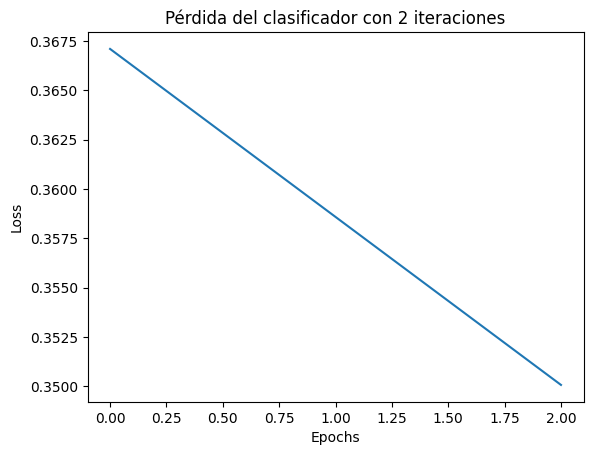

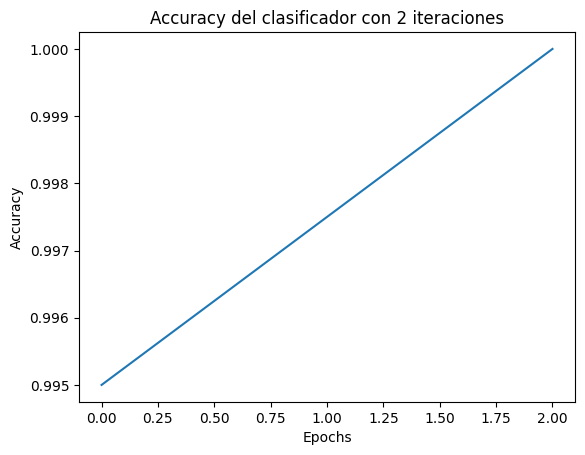

In [9]:
x_false = torch.randn(x_true.shape[0], GEN_INPUT_DIM).to(DEVICE)
x_true = x_true.to(DEVICE)
train_classifier(opt=opt_classifier, model = classifier, x_true = x_true, x_false = gen(x_false).reshape(x_true.shape), accuracy = 1, max_iter= 300)

Generator epochs:  408
Last loss: 0.2205137461423874


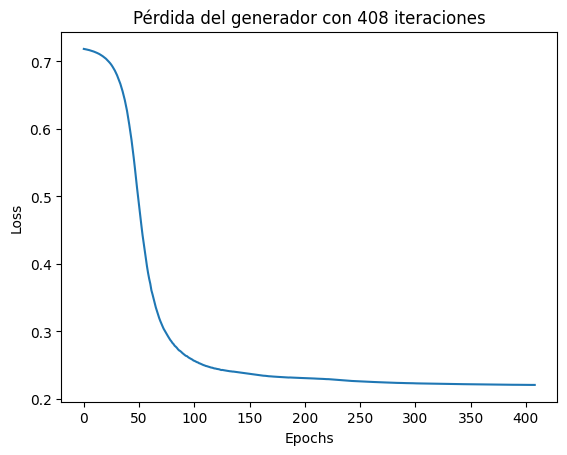

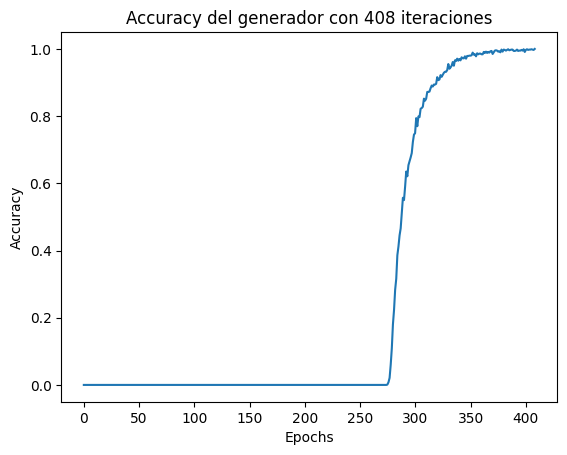

In [10]:
train_generator(opt=opt_generator, generator=gen, classifier=classifier, accuracy=1)

GAN Epoch: 0
Generator epochs:  1000


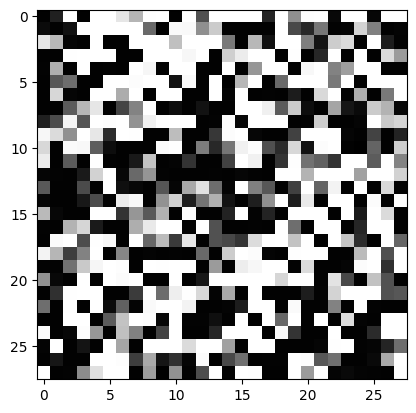

Classifier accuracy 1.0
GAN Epoch: 1
Generator epochs:  1000


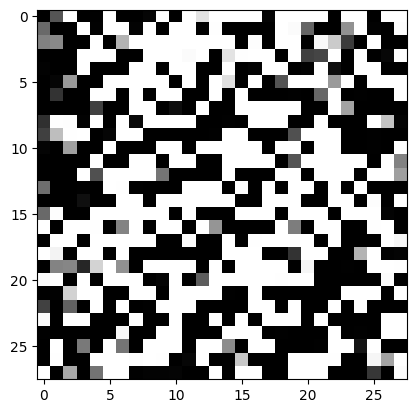

Classifier accuracy 1.0
GAN Epoch: 2
Generator epochs:  1000


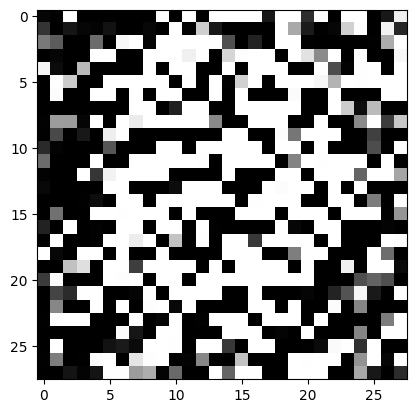

Classifier accuracy 1.0
GAN Epoch: 3
Generator epochs:  1000


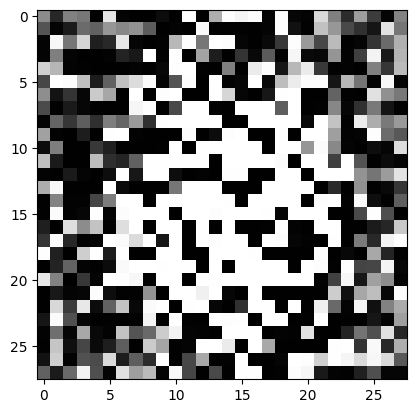

Classifier accuracy 1.0
GAN Epoch: 4
Generator epochs:  1000


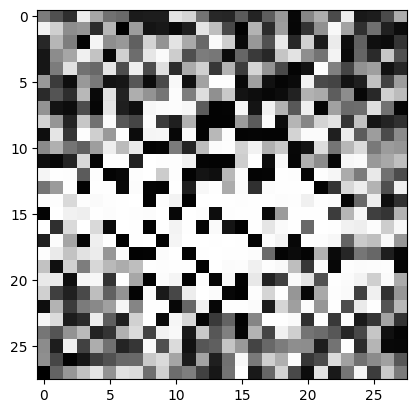

Classifier accuracy 1.0
GAN Epoch: 5
Generator epochs:  1000


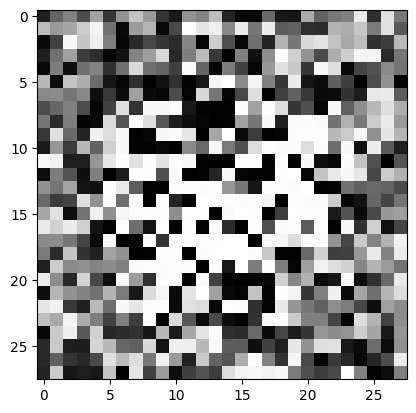

Classifier accuracy 1.0
GAN Epoch: 6
Generator epochs:  1000


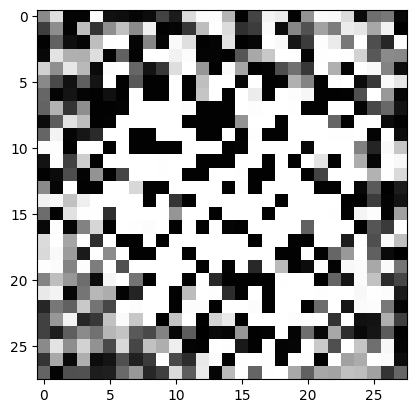

Classifier accuracy 1.0
GAN Epoch: 7
Generator epochs:  1000


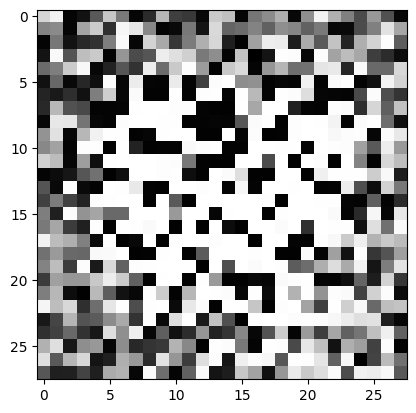

Classifier accuracy 1.0
GAN Epoch: 8
Generator epochs:  1000


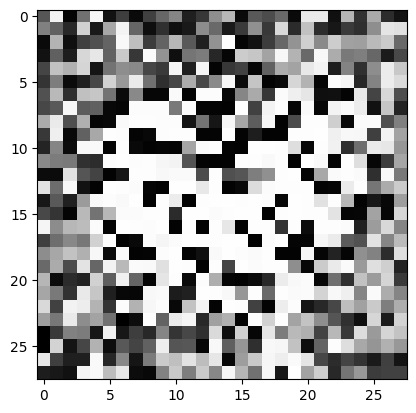

Classifier accuracy 1.0
GAN Epoch: 9
Generator epochs:  1000


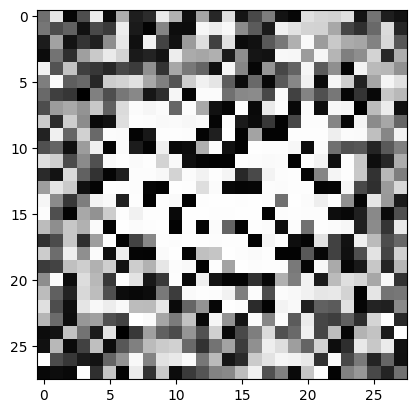

Classifier accuracy 1.0
GAN Epoch: 10
Generator epochs:  1000


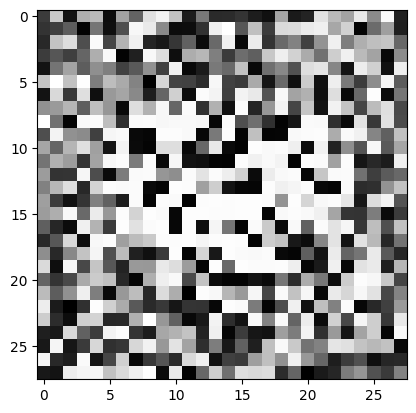

Classifier accuracy 1.0
GAN Epoch: 11
Generator epochs:  1000


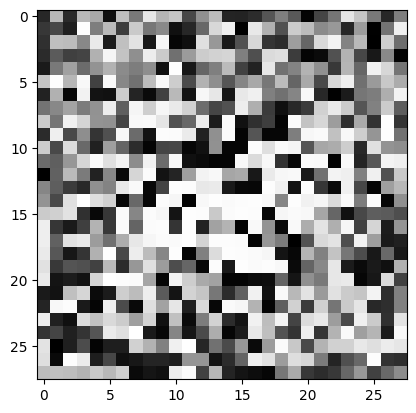

Classifier accuracy 1.0
GAN Epoch: 12
Generator epochs:  1000


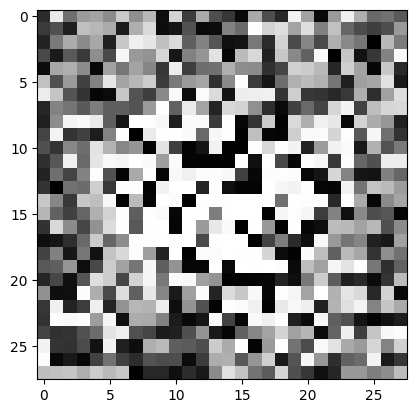

Classifier accuracy 1.0
GAN Epoch: 13
Generator epochs:  1000


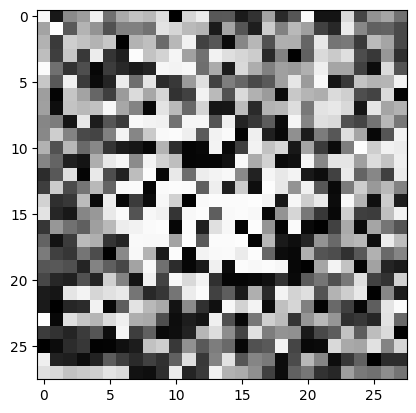

Classifier accuracy 1.0
GAN Epoch: 14
Generator epochs:  1000


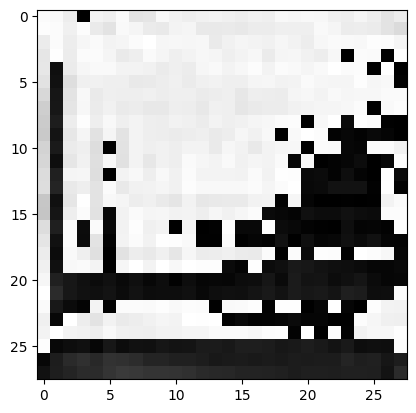

Classifier accuracy 1.0
GAN Epoch: 15
Generator epochs:  1000


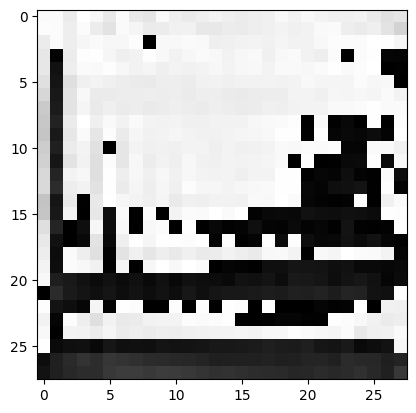

Classifier accuracy 1.0
GAN Epoch: 16
Generator epochs:  1000


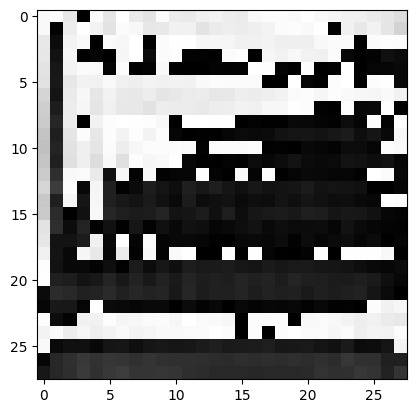

Classifier accuracy 1.0
GAN Epoch: 17
Generator epochs:  1000


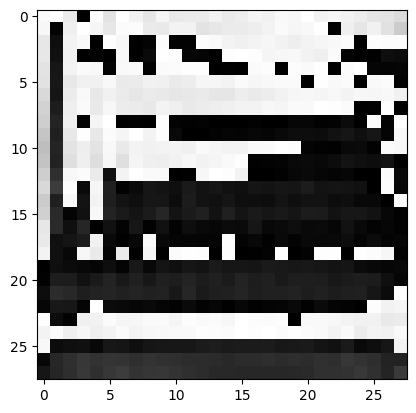

Classifier accuracy 1.0
GAN Epoch: 18
Generator epochs:  1000


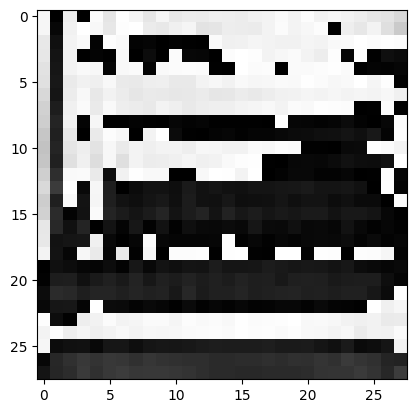

Classifier accuracy 1.0
GAN Epoch: 19
Generator epochs:  1000


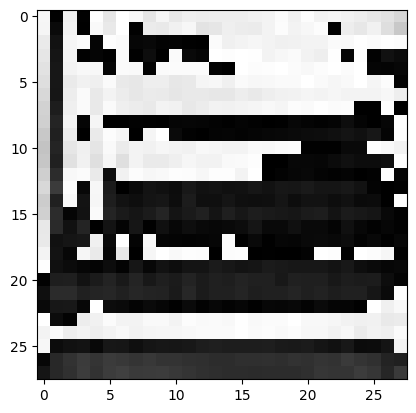

Classifier accuracy 1.0
GAN Epoch: 20
Generator epochs:  1000


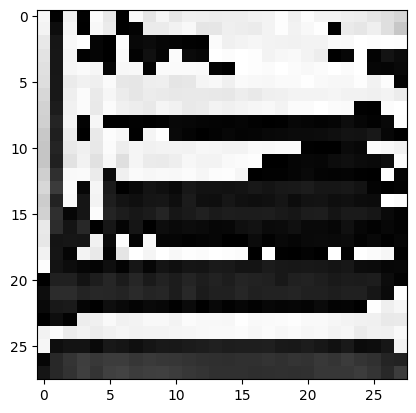

Classifier accuracy 1.0
GAN Epoch: 21
Generator epochs:  1000


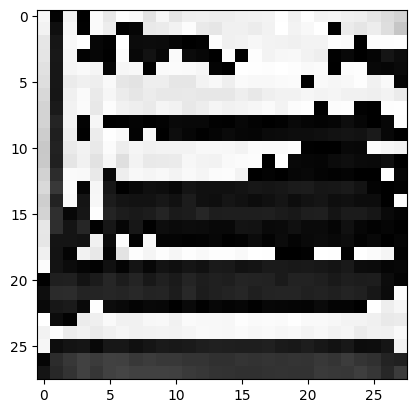

Classifier accuracy 1.0
GAN Epoch: 22
Generator epochs:  1000


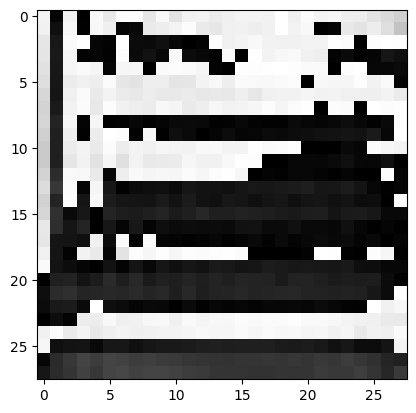

Classifier accuracy 1.0
GAN Epoch: 23
Generator epochs:  1000


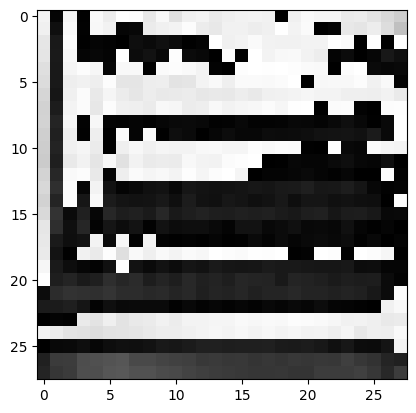

Classifier accuracy 1.0
GAN Epoch: 24
Generator epochs:  1000


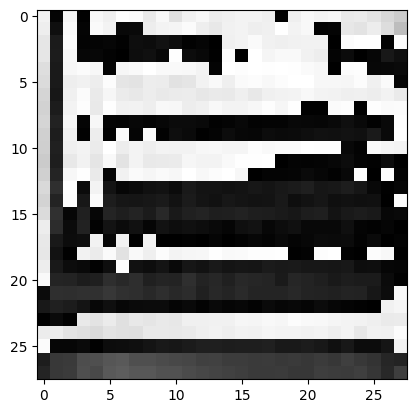

Classifier accuracy 1.0
GAN Epoch: 25
Generator epochs:  1000


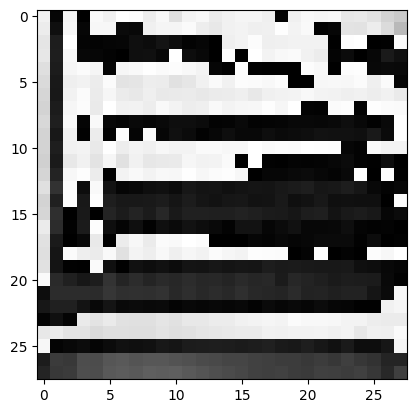

Classifier accuracy 1.0
GAN Epoch: 26
Generator epochs:  1000


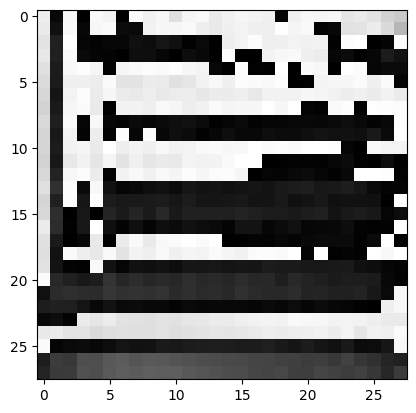

Classifier accuracy 1.0
GAN Epoch: 27
Generator epochs:  1000


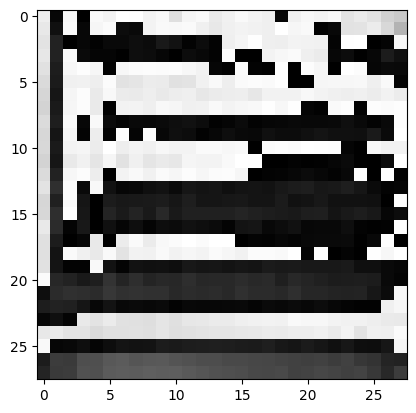

Classifier accuracy 1.0
GAN Epoch: 28
Generator epochs:  1000


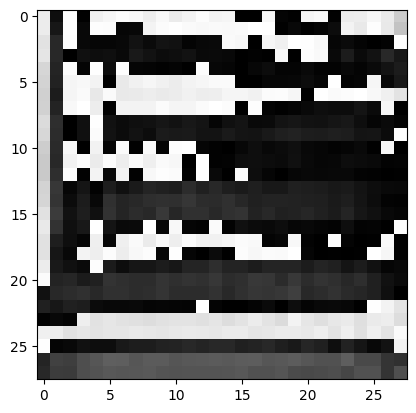

Classifier accuracy 1.0
GAN Epoch: 29
Generator epochs:  1000


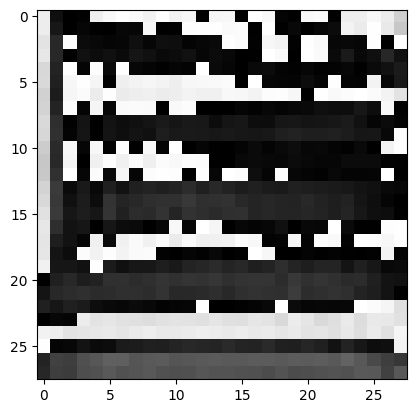

Classifier accuracy 1.0
GAN Epoch: 30
Generator epochs:  1000


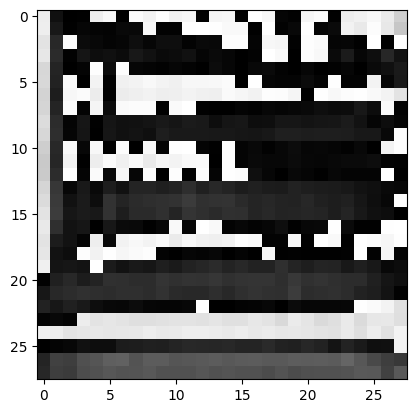

Classifier accuracy 1.0
GAN Epoch: 31
Generator epochs:  1000


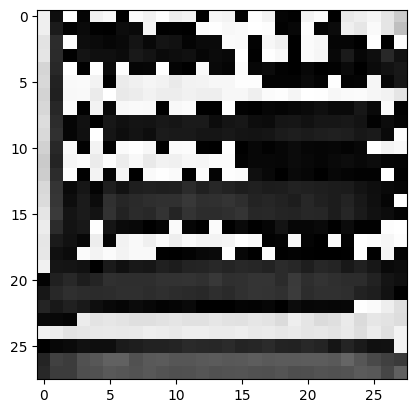

Classifier accuracy 1.0
GAN Epoch: 32
Generator epochs:  1000


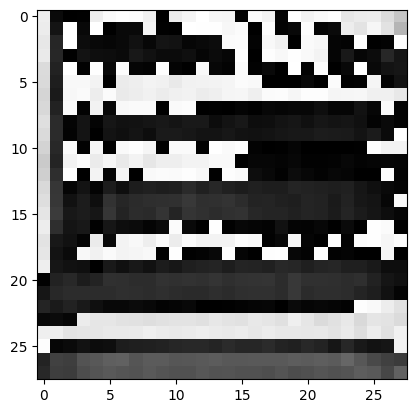

Classifier accuracy 1.0
GAN Epoch: 33
Generator epochs:  1000


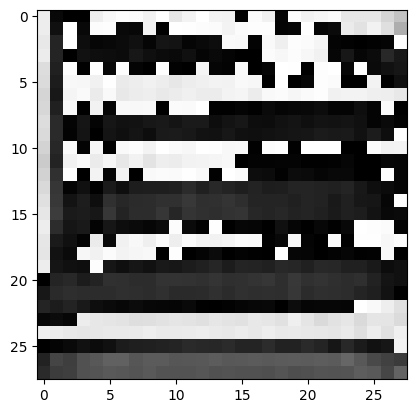

Classifier accuracy 1.0
GAN Epoch: 34
Generator epochs:  1000


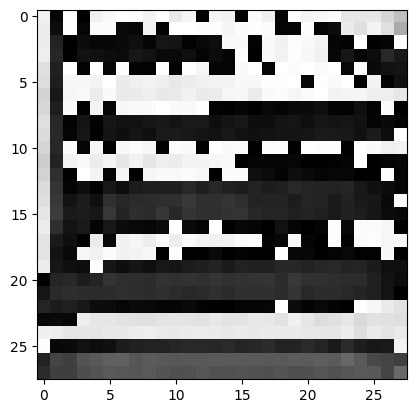

Classifier accuracy 1.0
GAN Epoch: 35
Generator epochs:  1000


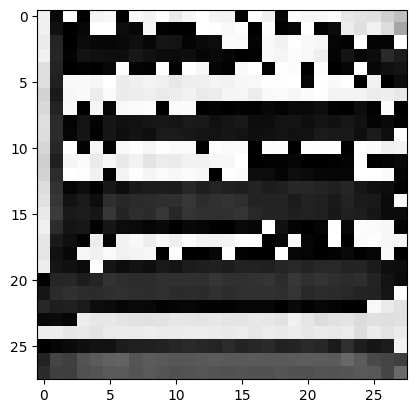

Classifier accuracy 1.0
GAN Epoch: 36
Generator epochs:  1000


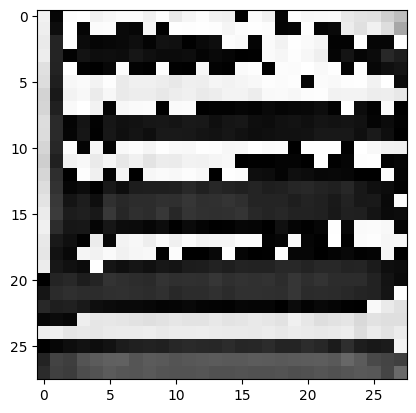

Classifier accuracy 1.0
GAN Epoch: 37
Generator epochs:  1000


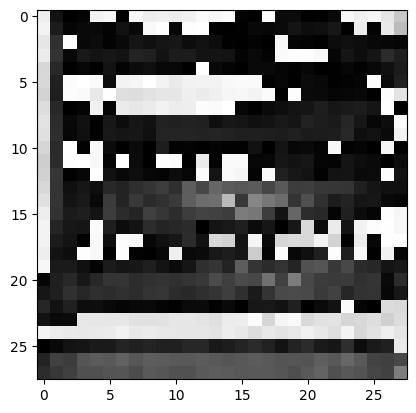

Classifier accuracy 1.0
GAN Epoch: 38
Generator epochs:  1000


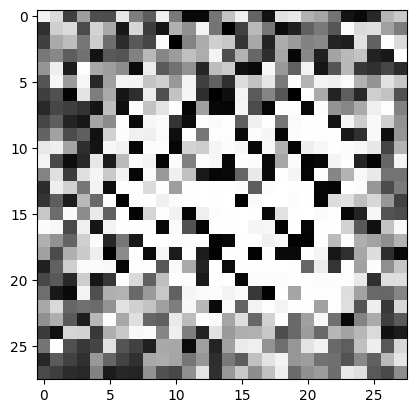

Classifier accuracy 1.0
GAN Epoch: 39
Generator epochs:  1000


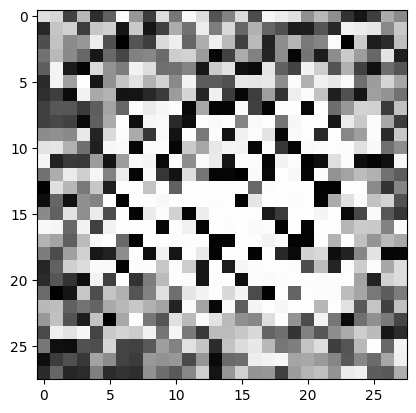

Classifier accuracy 1.0
GAN Epoch: 40
Generator epochs:  1000


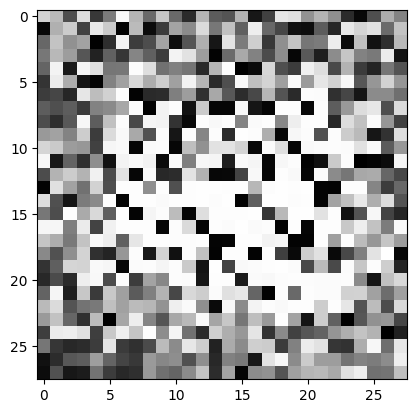

Classifier accuracy 1.0
GAN Epoch: 41
Generator epochs:  1000


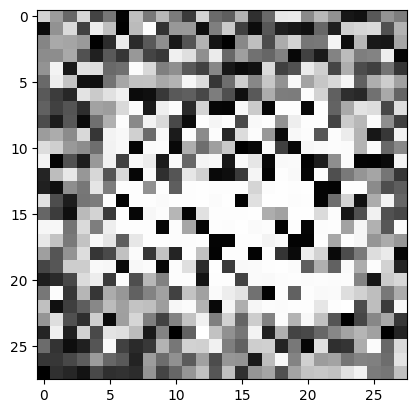

Classifier accuracy 1.0
GAN Epoch: 42
Generator epochs:  1000


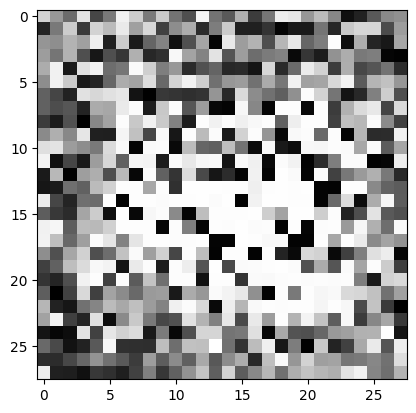

Classifier accuracy 1.0
GAN Epoch: 43
Generator epochs:  1000


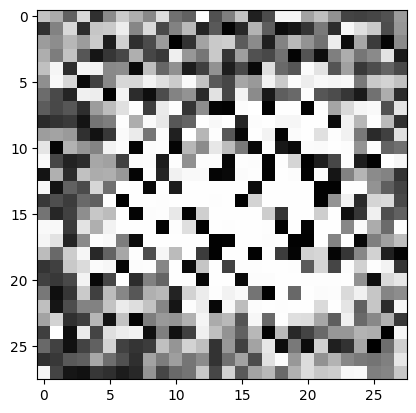

Classifier accuracy 1.0
GAN Epoch: 44
Generator epochs:  1000


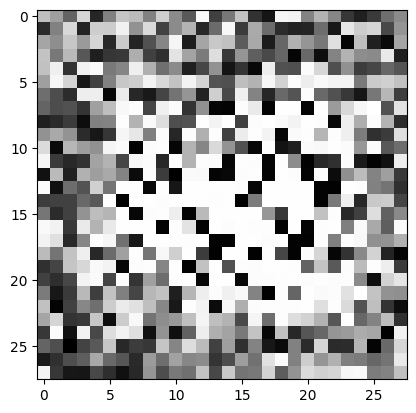

Classifier accuracy 1.0
GAN Epoch: 45
Generator epochs:  1000


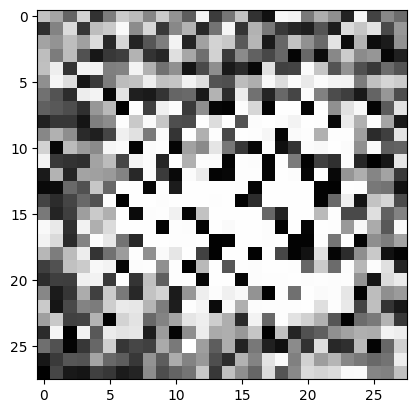

Classifier accuracy 1.0
GAN Epoch: 46
Generator epochs:  1000


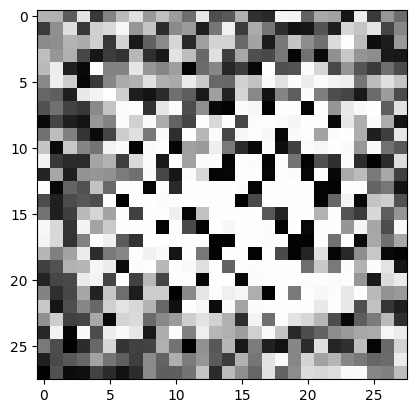

Classifier accuracy 1.0
GAN Epoch: 47
Generator epochs:  1000


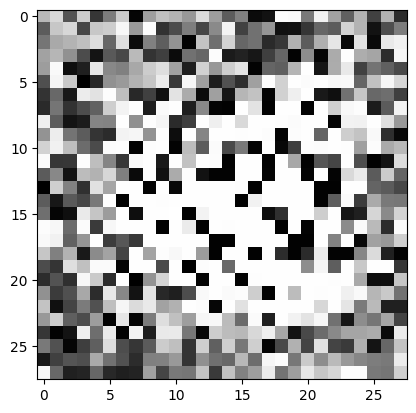

Classifier accuracy 1.0
GAN Epoch: 48
Generator epochs:  1000


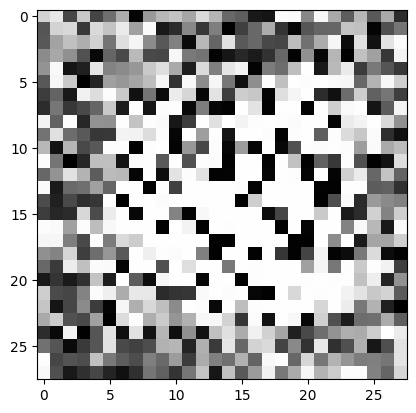

Classifier accuracy 1.0
GAN Epoch: 49
Generator epochs:  1000


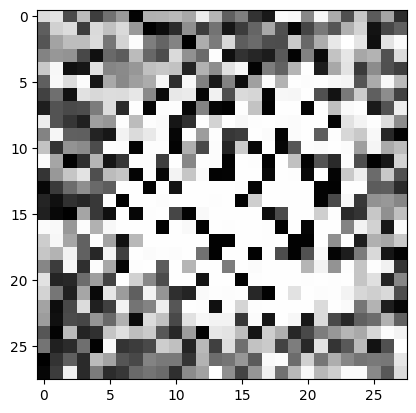

Classifier accuracy 1.0
GAN Epoch: 50
Generator epochs:  1000


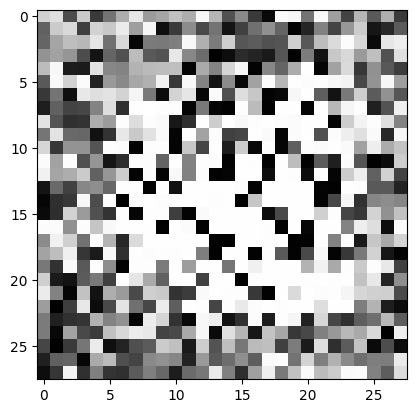

Classifier accuracy 1.0
GAN Epoch: 51
Generator epochs:  1000


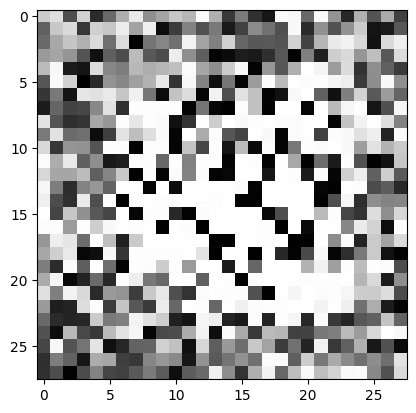

Classifier accuracy 1.0
GAN Epoch: 52
Generator epochs:  1000


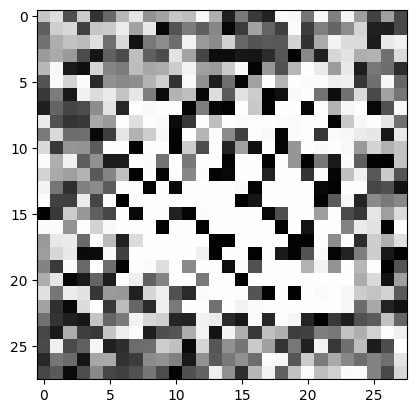

Classifier accuracy 1.0
GAN Epoch: 53
Generator epochs:  1000


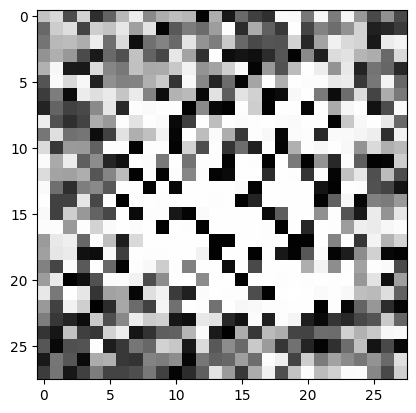

Classifier accuracy 1.0
GAN Epoch: 54
Generator epochs:  1000


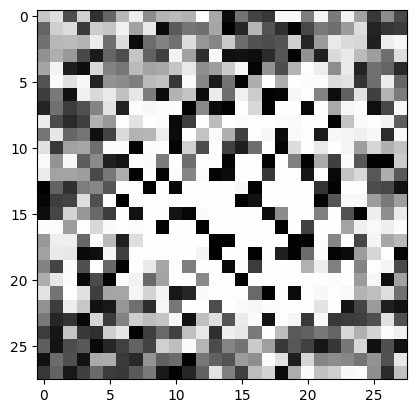

Classifier accuracy 1.0
GAN Epoch: 55
Generator epochs:  1000


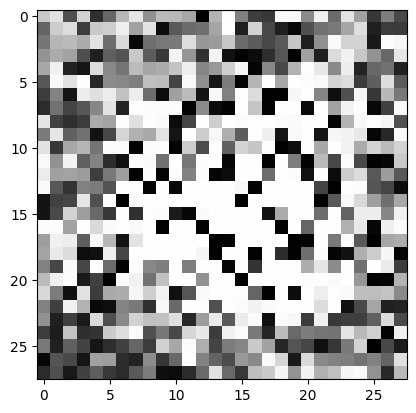

Classifier accuracy 1.0
GAN Epoch: 56
Generator epochs:  1000


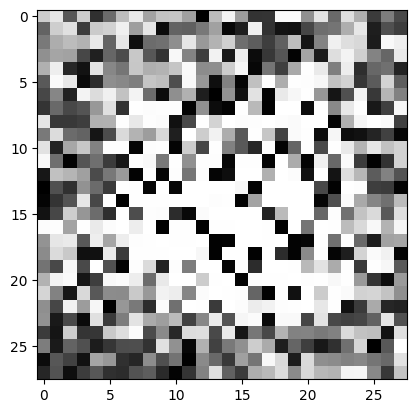

Classifier accuracy 1.0
GAN Epoch: 57
Generator epochs:  1000


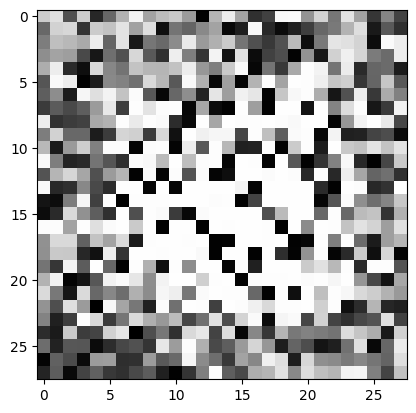

Classifier accuracy 1.0
GAN Epoch: 58
Generator epochs:  1000


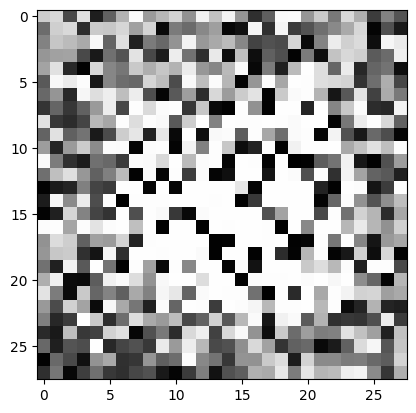

Classifier accuracy 1.0
GAN Epoch: 59
Generator epochs:  1000


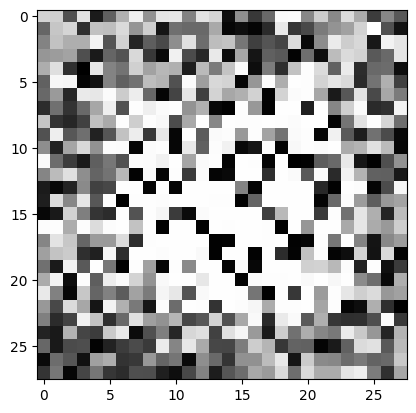

Classifier accuracy 1.0
GAN Epoch: 60
Generator epochs:  1000


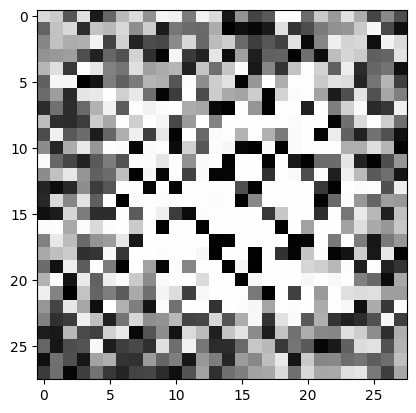

Classifier accuracy 1.0
GAN Epoch: 61
Generator epochs:  1000


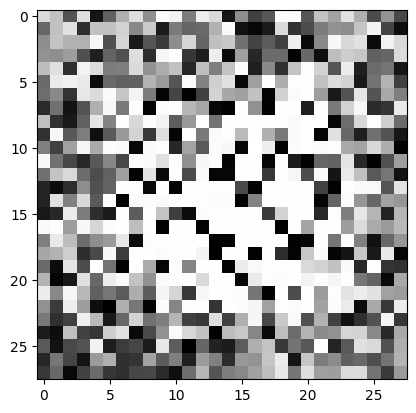

Classifier accuracy 1.0
GAN Epoch: 62
Generator epochs:  1000


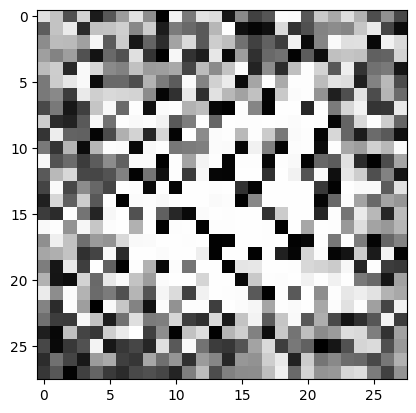

Classifier accuracy 1.0
GAN Epoch: 63
Generator epochs:  1000


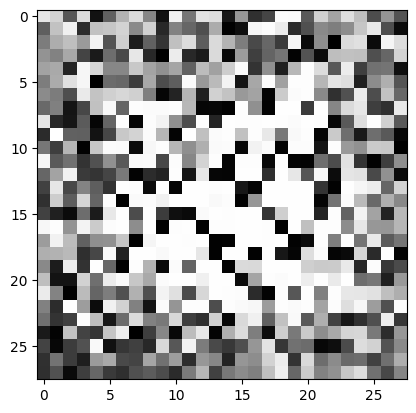

Classifier accuracy 1.0
GAN Epoch: 64
Generator epochs:  1000


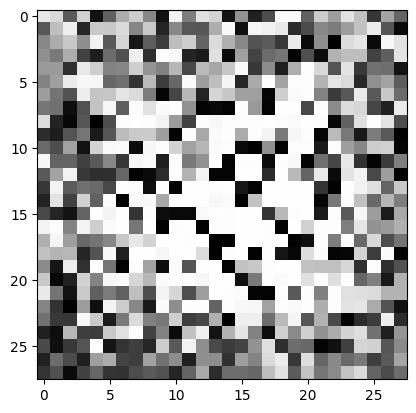

Classifier accuracy 1.0
GAN Epoch: 65
Generator epochs:  1000


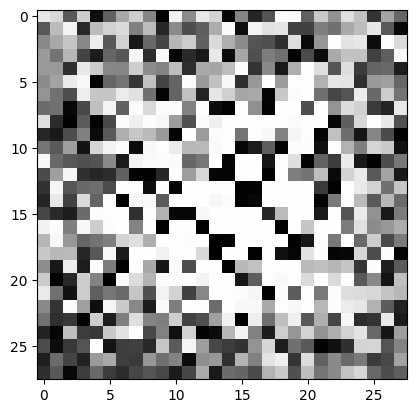

Classifier accuracy 1.0
GAN Epoch: 66
Generator epochs:  1000


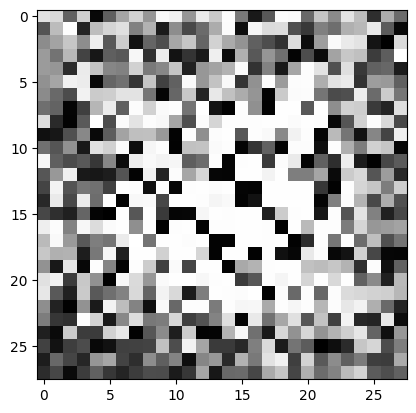

Classifier accuracy 1.0
GAN Epoch: 67
Generator epochs:  1000


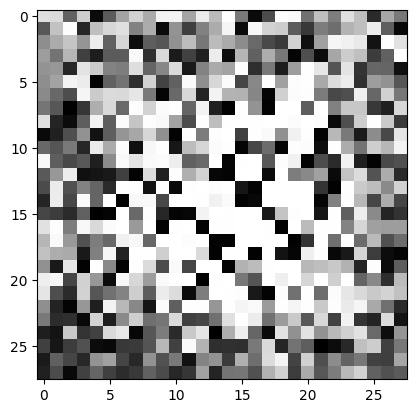

Classifier accuracy 1.0
GAN Epoch: 68
Generator epochs:  1000


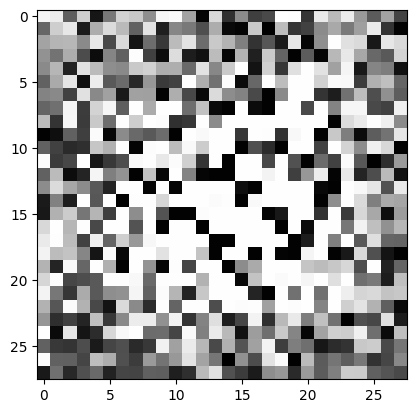

Classifier accuracy 1.0
GAN Epoch: 69
Generator epochs:  1000


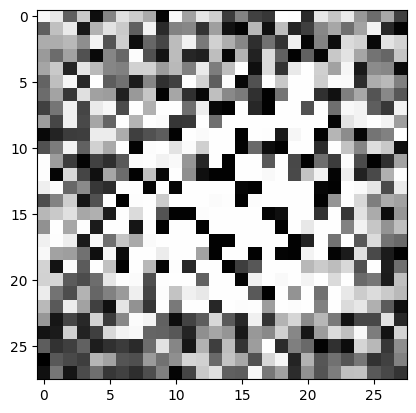

Classifier accuracy 1.0
GAN Epoch: 70
Generator epochs:  1000


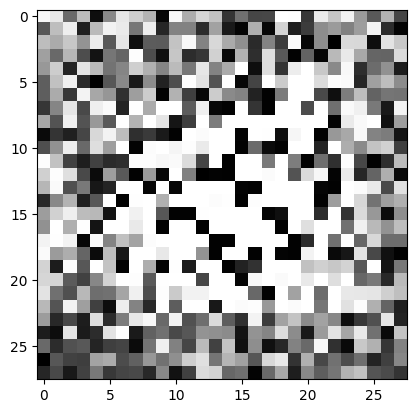

Classifier accuracy 1.0
GAN Epoch: 71
Generator epochs:  1000


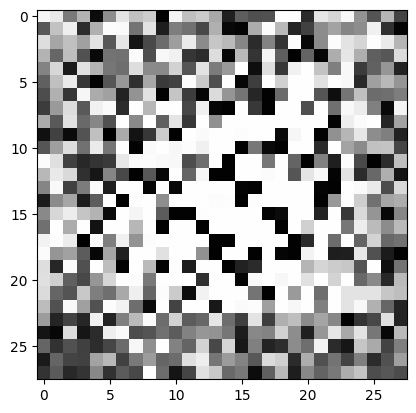

Classifier accuracy 1.0
GAN Epoch: 72
Generator epochs:  1000


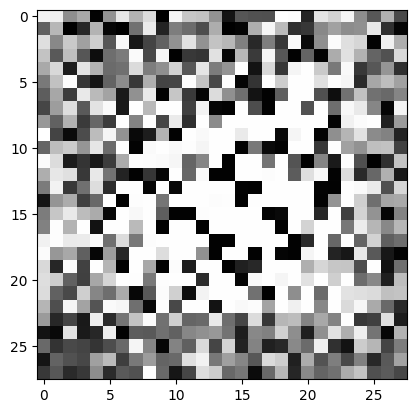

Classifier accuracy 1.0
GAN Epoch: 73
Generator epochs:  1000


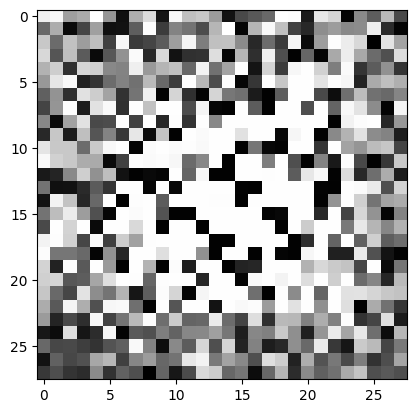

Classifier accuracy 1.0
GAN Epoch: 74
Generator epochs:  1000


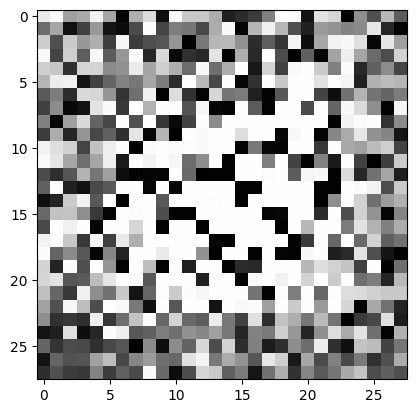

Classifier accuracy 1.0
GAN Epoch: 75
Generator epochs:  1000


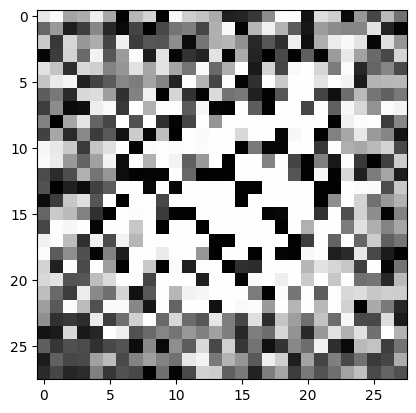

Classifier accuracy 1.0
GAN Epoch: 76
Generator epochs:  1000


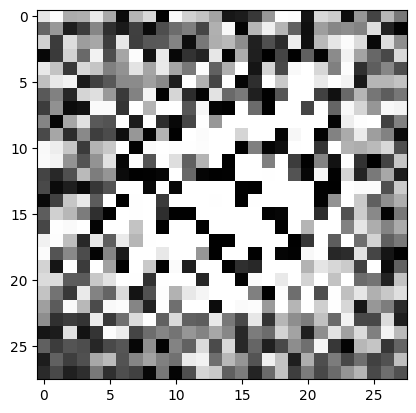

Classifier accuracy 1.0
GAN Epoch: 77
Generator epochs:  1000


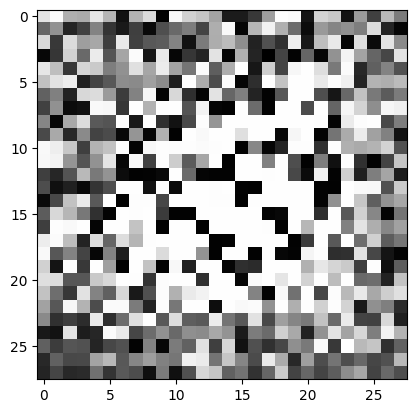

Classifier accuracy 1.0
GAN Epoch: 78
Generator epochs:  1000


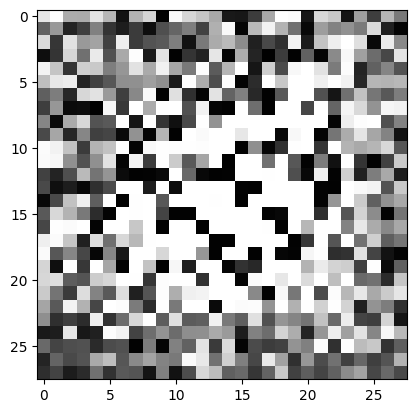

Classifier accuracy 1.0
GAN Epoch: 79
Generator epochs:  1000


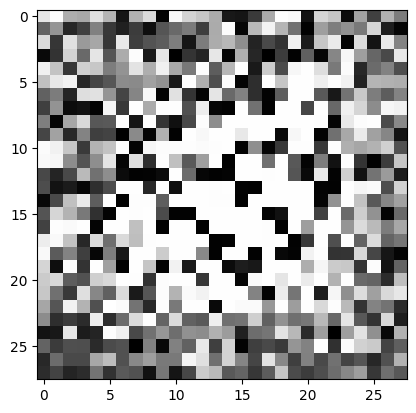

Classifier accuracy 1.0
GAN Epoch: 80
Generator epochs:  1000


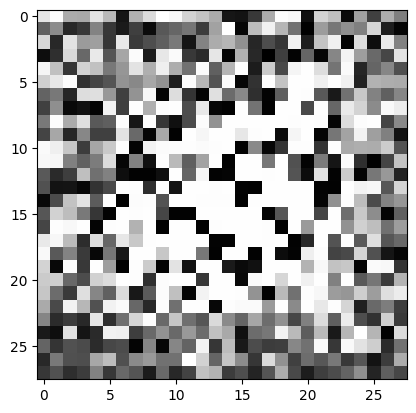

Classifier accuracy 1.0
GAN Epoch: 81
Generator epochs:  1000


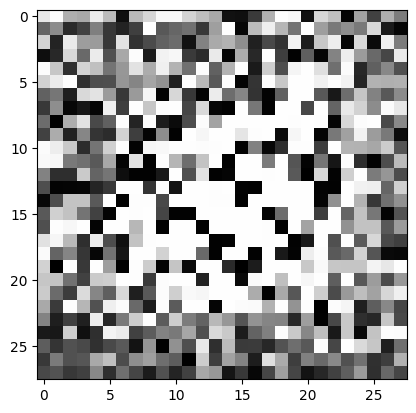

Classifier accuracy 1.0
GAN Epoch: 82
Generator epochs:  1000


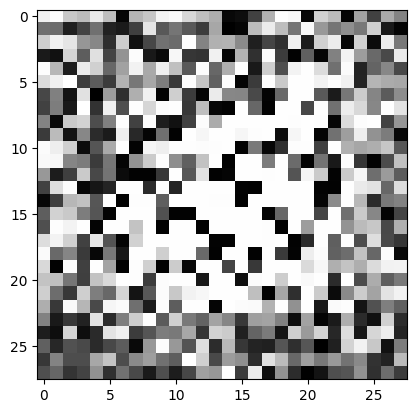

Classifier accuracy 1.0
GAN Epoch: 83
Generator epochs:  1000


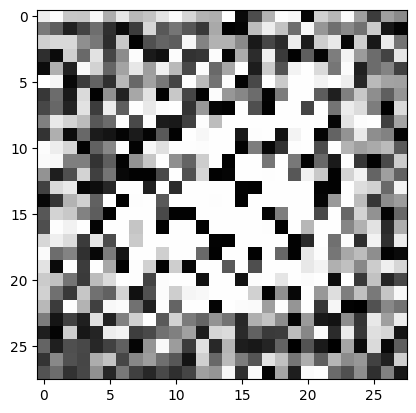

Classifier accuracy 1.0
GAN Epoch: 84
Generator epochs:  1000


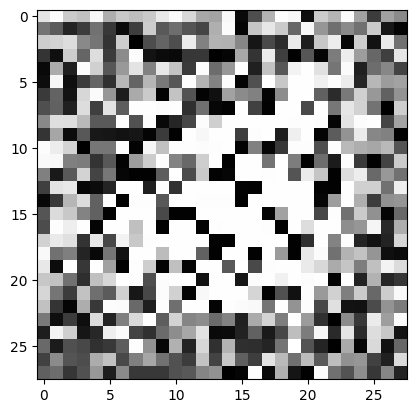

Classifier accuracy 1.0
GAN Epoch: 85
Generator epochs:  1000


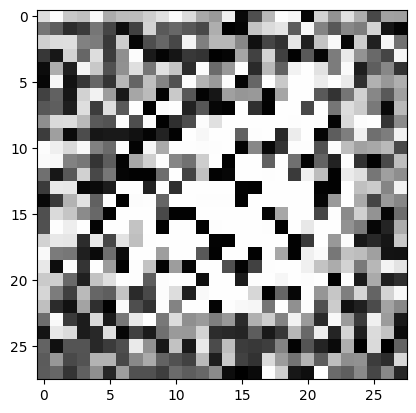

Classifier accuracy 1.0
GAN Epoch: 86
Generator epochs:  1000


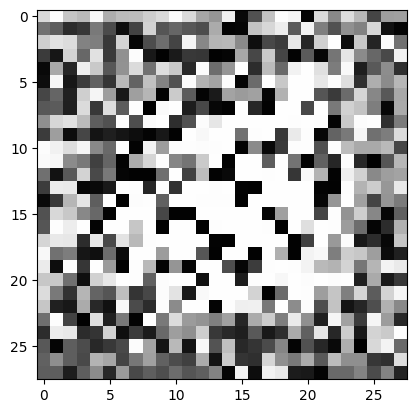

Classifier accuracy 1.0
GAN Epoch: 87
Generator epochs:  1000


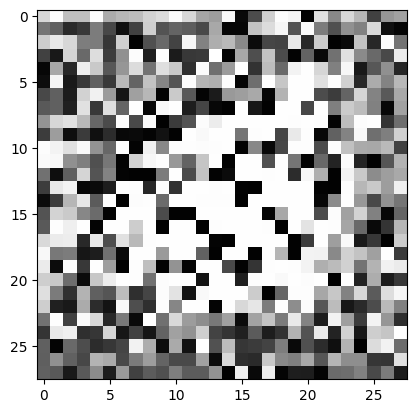

Classifier accuracy 1.0
GAN Epoch: 88
Generator epochs:  1000


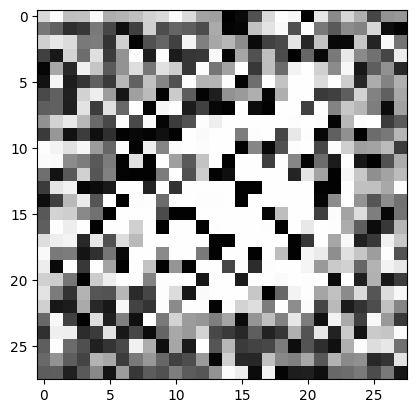

Classifier accuracy 1.0
GAN Epoch: 89
Generator epochs:  1000


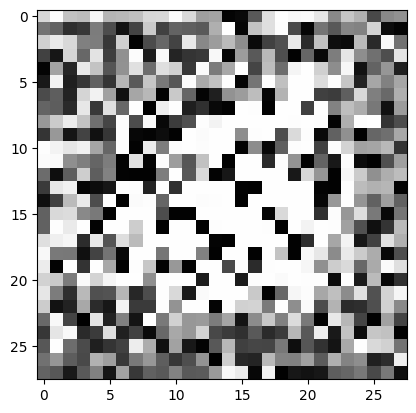

Classifier accuracy 1.0
GAN Epoch: 90
Generator epochs:  1000


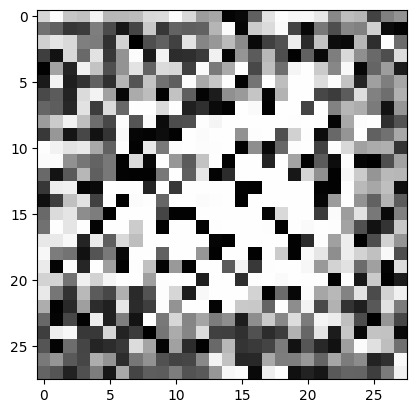

Classifier accuracy 1.0
GAN Epoch: 91
Generator epochs:  1000


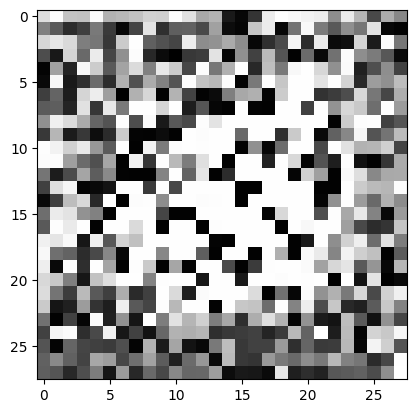

Classifier accuracy 1.0
GAN Epoch: 92
Generator epochs:  1000


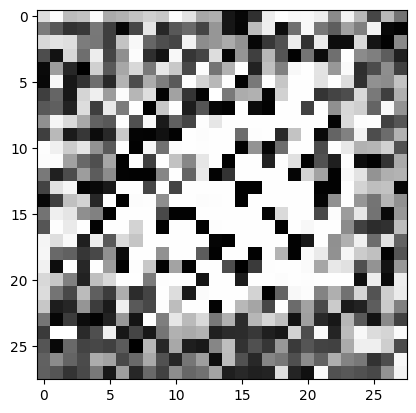

Classifier accuracy 1.0
GAN Epoch: 93
Generator epochs:  1000


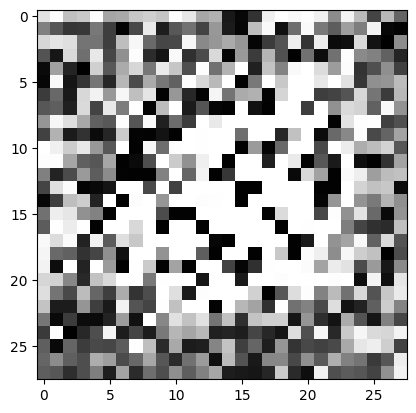

Classifier accuracy 1.0
GAN Epoch: 94
Generator epochs:  1000


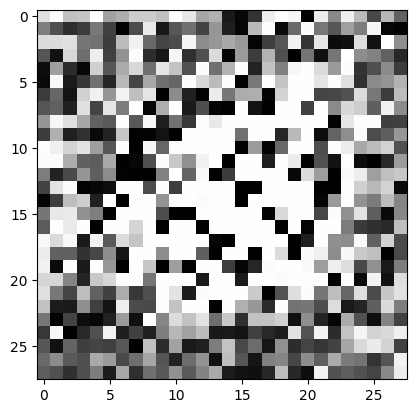

Classifier accuracy 1.0
GAN Epoch: 95
Generator epochs:  1000


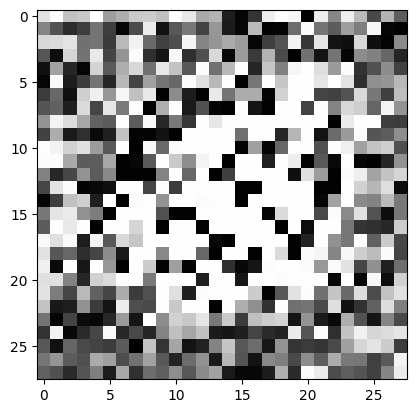

Classifier accuracy 1.0
GAN Epoch: 96
Generator epochs:  1000


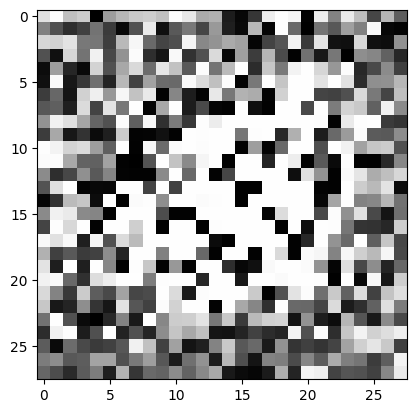

Classifier accuracy 1.0
GAN Epoch: 97
Generator epochs:  1000


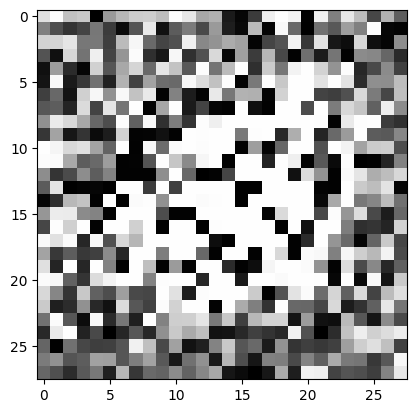

Classifier accuracy 1.0
GAN Epoch: 98
Generator epochs:  1000


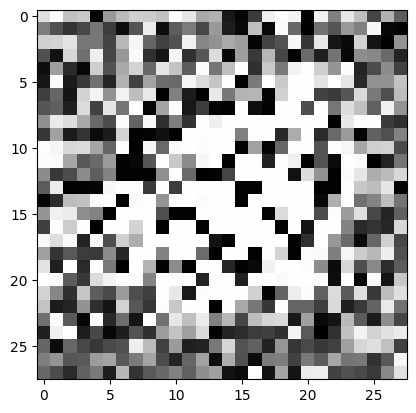

Classifier accuracy 1.0
GAN Epoch: 99
Generator epochs:  1000


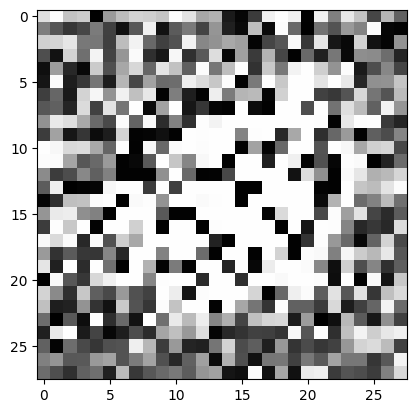

Classifier accuracy 1.0
GAN Epoch: 100
Generator epochs:  1000


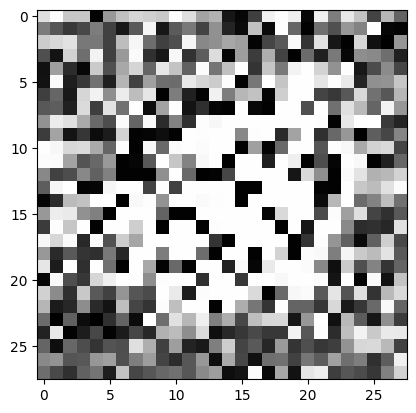

Classifier accuracy 1.0
GAN Epoch: 101
Generator epochs:  1000


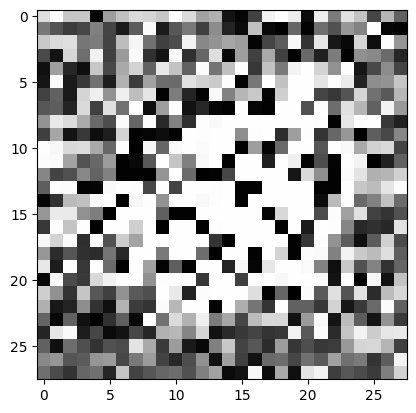

Classifier accuracy 1.0
GAN Epoch: 102
Generator epochs:  1000


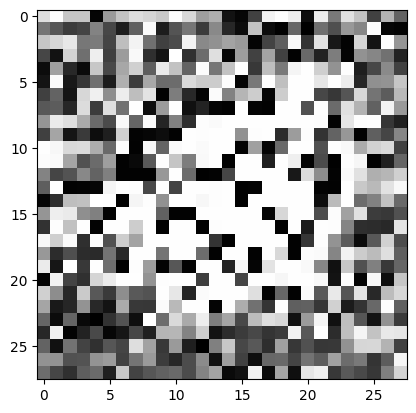

Classifier accuracy 1.0
GAN Epoch: 103
Generator epochs:  1000


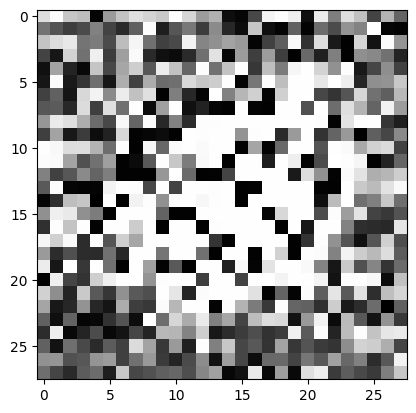

Classifier accuracy 1.0
GAN Epoch: 104
Generator epochs:  1000


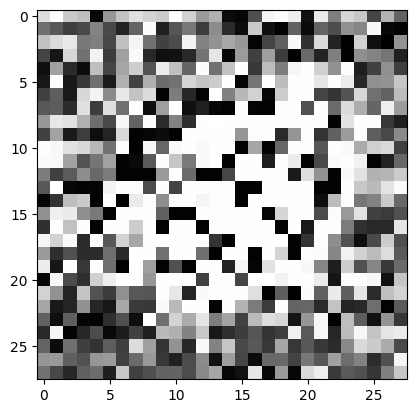

Classifier accuracy 1.0
GAN Epoch: 105
Generator epochs:  1000


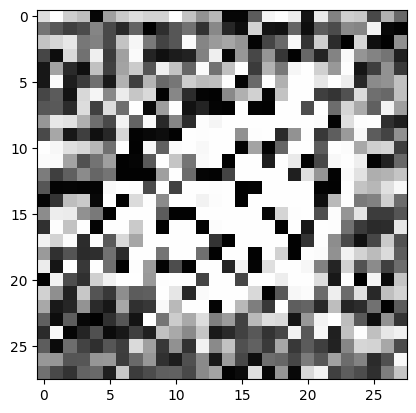

Classifier accuracy 1.0
GAN Epoch: 106
Generator epochs:  1000


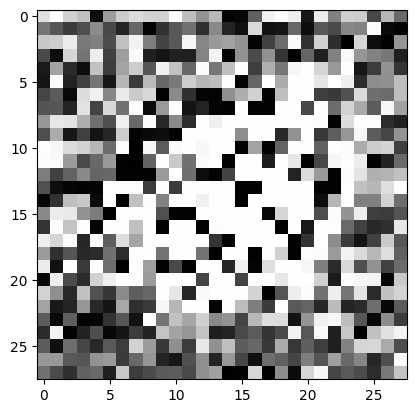

Classifier accuracy 1.0
GAN Epoch: 107
Generator epochs:  1000


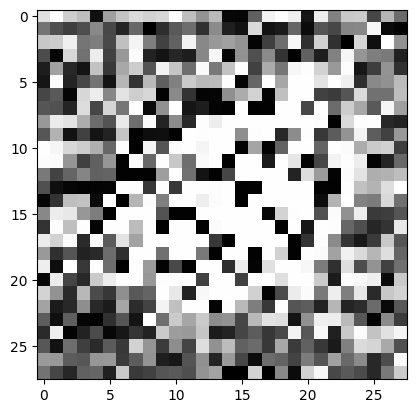

Classifier accuracy 1.0
GAN Epoch: 108
Generator epochs:  1000


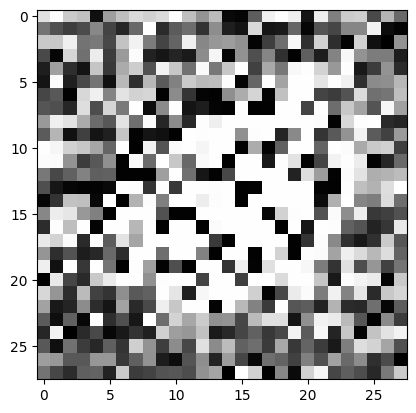

Classifier accuracy 1.0
GAN Epoch: 109
Generator epochs:  1000


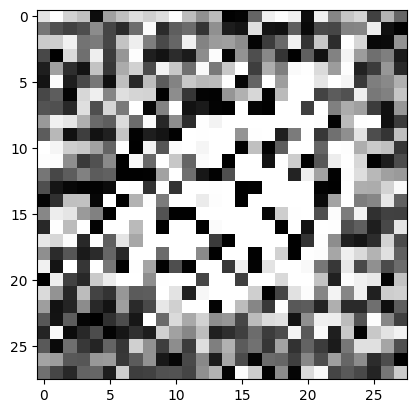

Classifier accuracy 1.0
GAN Epoch: 110
Generator epochs:  1000


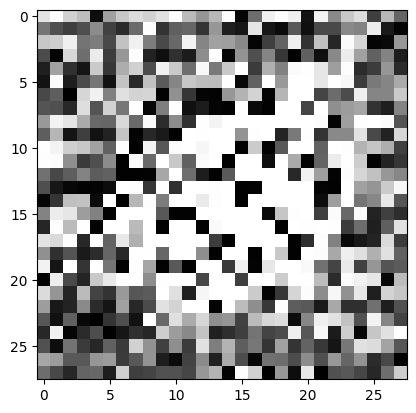

Classifier accuracy 1.0
GAN Epoch: 111
Generator epochs:  1000


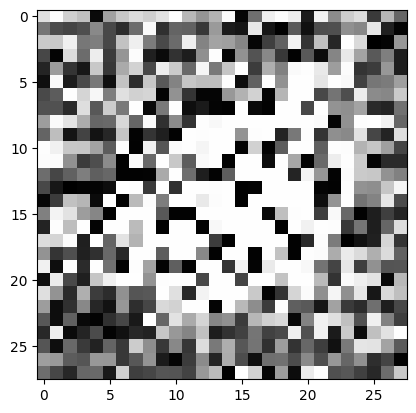

Classifier accuracy 1.0
GAN Epoch: 112
Generator epochs:  1000


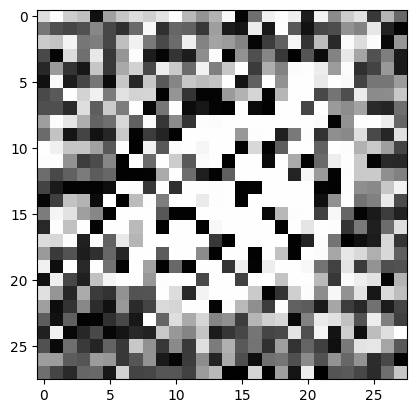

Classifier accuracy 1.0
GAN Epoch: 113
Generator epochs:  1000


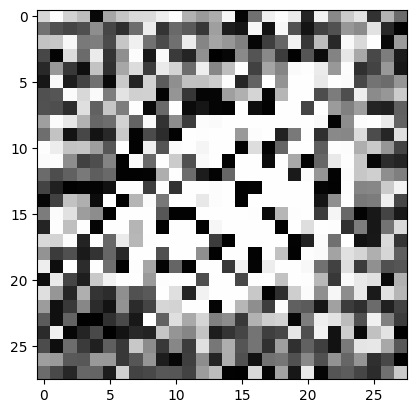

Classifier accuracy 1.0
GAN Epoch: 114
Generator epochs:  1000


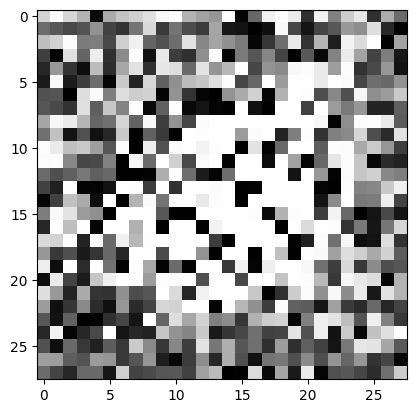

Classifier accuracy 1.0
GAN Epoch: 115
Generator epochs:  1000


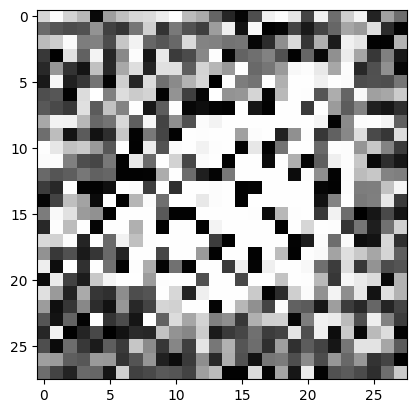

Classifier accuracy 1.0
GAN Epoch: 116
Generator epochs:  1000


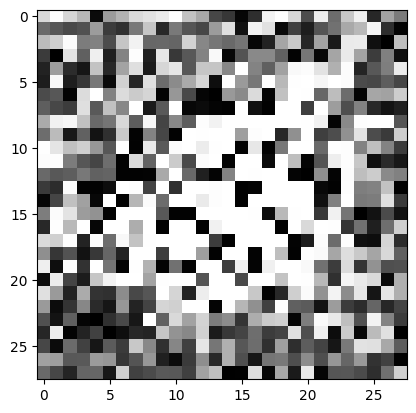

Classifier accuracy 1.0
GAN Epoch: 117
Generator epochs:  1000


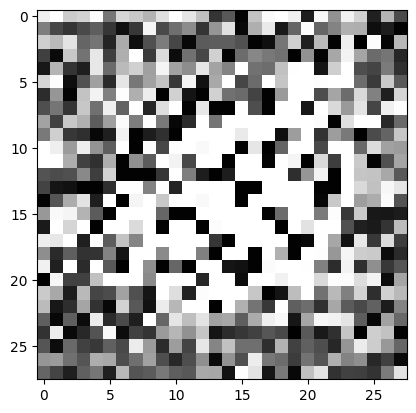

Classifier accuracy 1.0
GAN Epoch: 118
Generator epochs:  1000


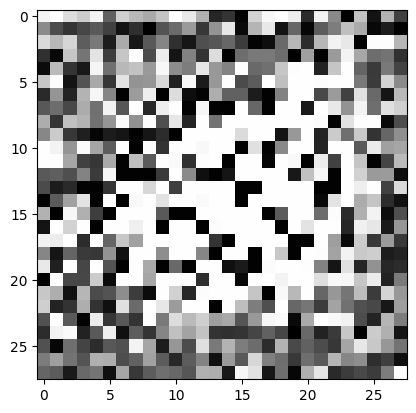

Classifier accuracy 1.0
GAN Epoch: 119
Generator epochs:  1000


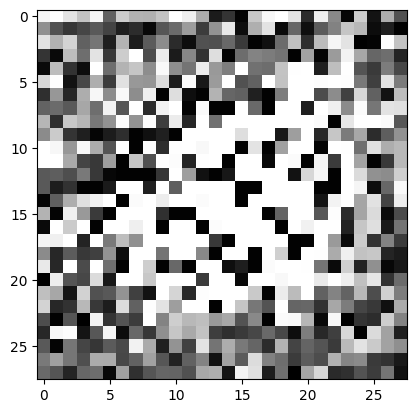

Classifier accuracy 1.0
GAN Epoch: 120
Generator epochs:  1000


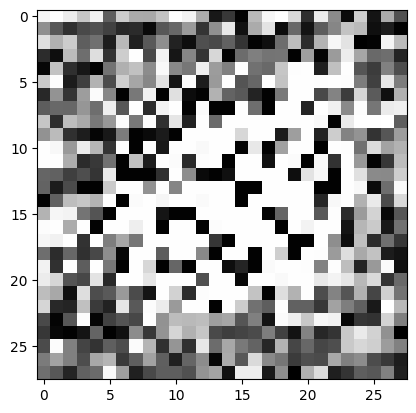

Classifier accuracy 1.0
GAN Epoch: 121
Generator epochs:  1000


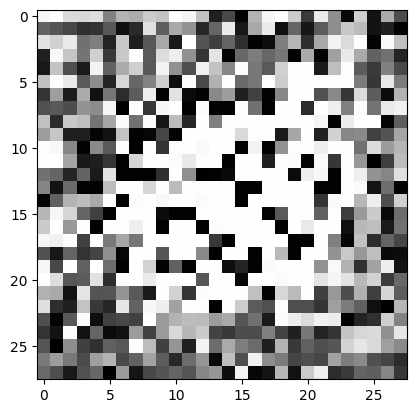

Classifier accuracy 1.0
GAN Epoch: 122
Generator epochs:  1000


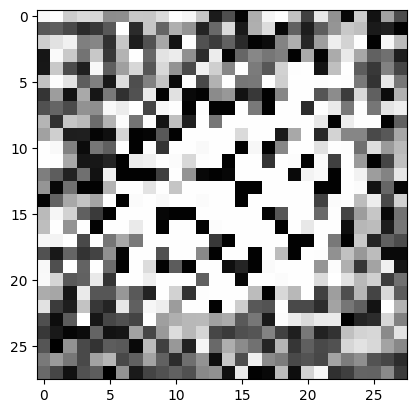

Classifier accuracy 1.0
GAN Epoch: 123
Generator epochs:  1000


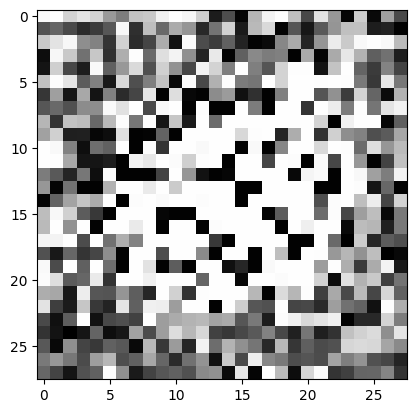

Classifier accuracy 1.0
GAN Epoch: 124
Generator epochs:  1000


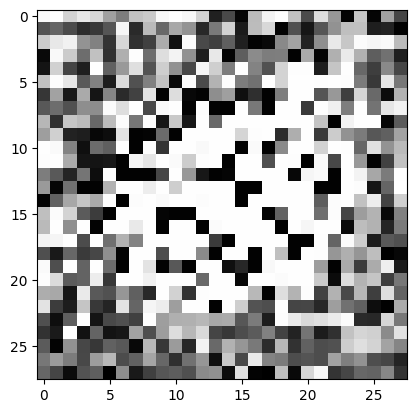

Classifier accuracy 1.0
GAN Epoch: 125
Generator epochs:  1000


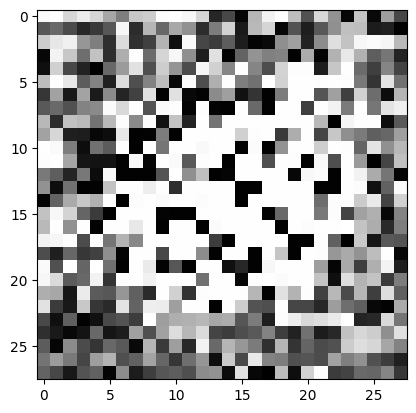

Classifier accuracy 1.0
GAN Epoch: 126
Generator epochs:  1000


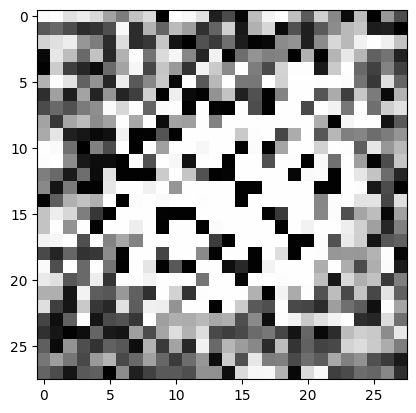

Classifier accuracy 1.0
GAN Epoch: 127
Generator epochs:  1000


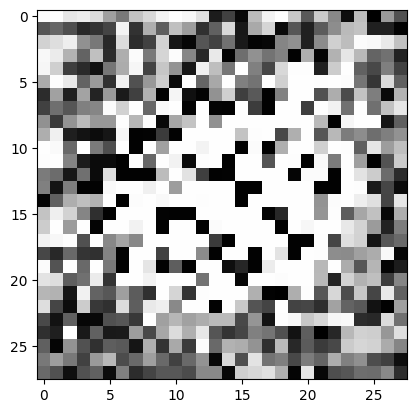

Classifier accuracy 1.0
GAN Epoch: 128
Generator epochs:  1000


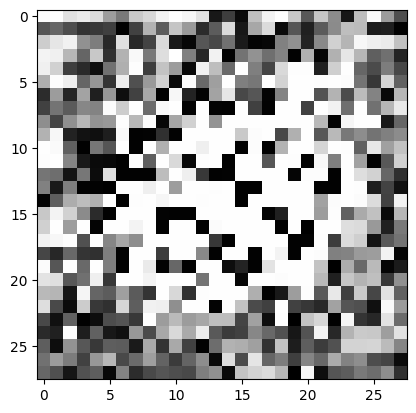

Classifier accuracy 1.0
GAN Epoch: 129
Generator epochs:  1000


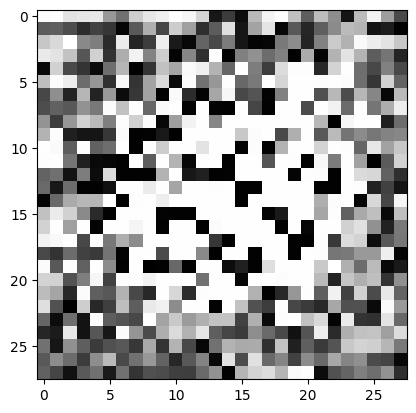

Classifier accuracy 1.0
GAN Epoch: 130
Generator epochs:  1000


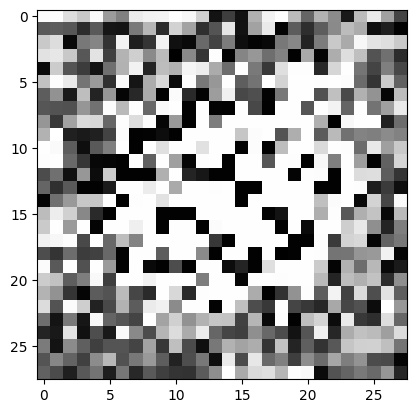

Classifier accuracy 1.0
GAN Epoch: 131
Generator epochs:  1000


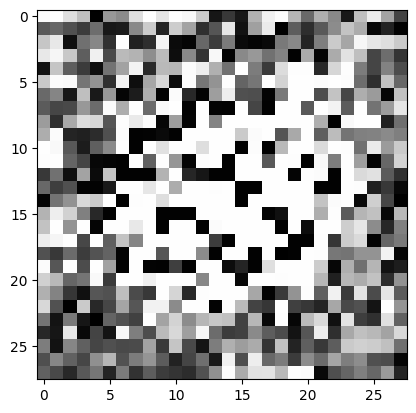

Classifier accuracy 1.0
GAN Epoch: 132
Generator epochs:  1000


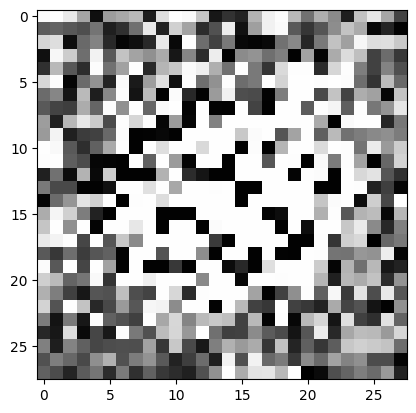

Classifier accuracy 1.0
GAN Epoch: 133
Generator epochs:  1000


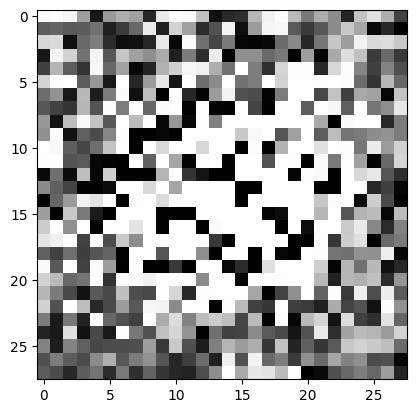

Classifier accuracy 1.0
GAN Epoch: 134
Generator epochs:  1000


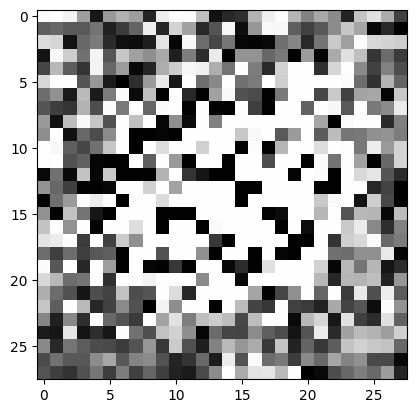

Classifier accuracy 1.0
GAN Epoch: 135
Generator epochs:  1000


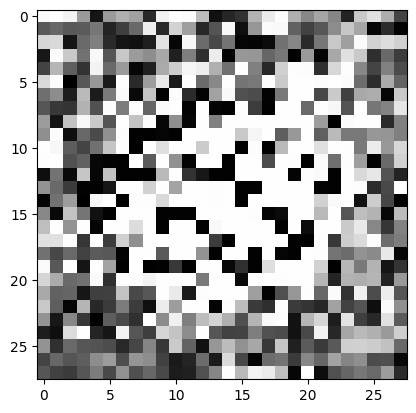

Classifier accuracy 1.0
GAN Epoch: 136
Generator epochs:  1000


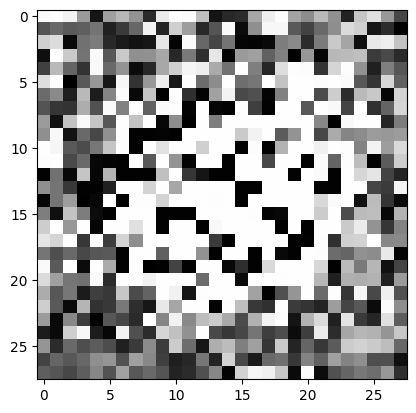

Classifier accuracy 1.0
GAN Epoch: 137
Generator epochs:  1000


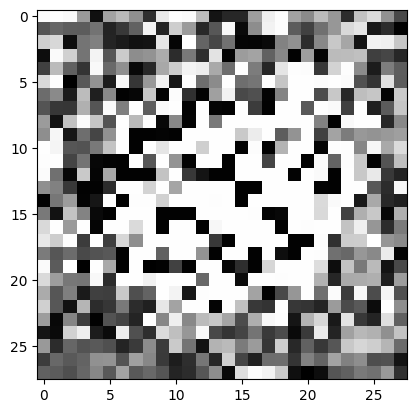

Classifier accuracy 1.0
GAN Epoch: 138
Generator epochs:  1000


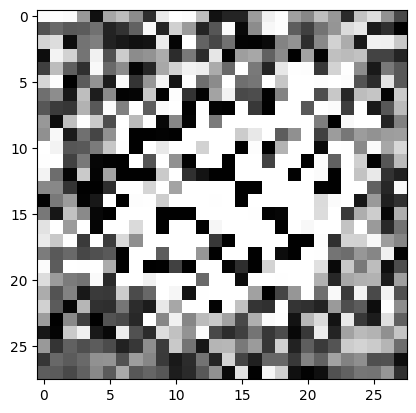

Classifier accuracy 1.0
GAN Epoch: 139
Generator epochs:  1000


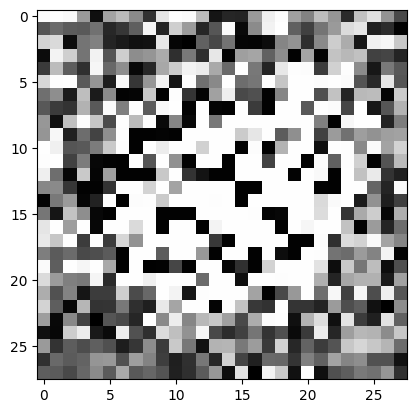

Classifier accuracy 1.0
GAN Epoch: 140
Generator epochs:  1000


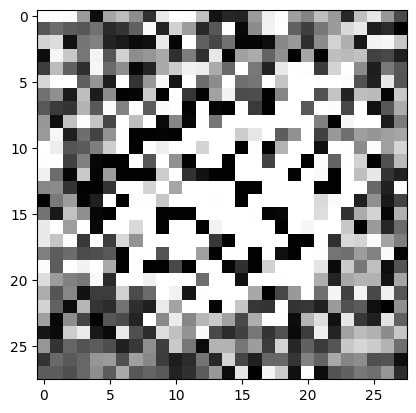

Classifier accuracy 1.0
GAN Epoch: 141
Generator epochs:  1000


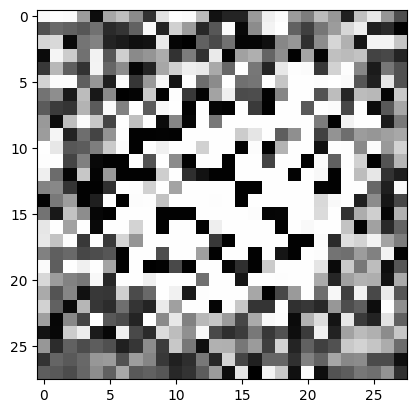

Classifier accuracy 1.0
GAN Epoch: 142
Generator epochs:  1000


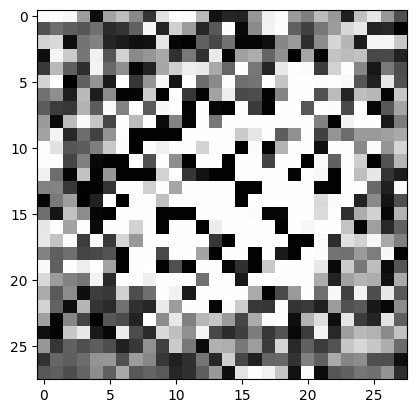

Classifier accuracy 1.0
GAN Epoch: 143
Generator epochs:  1000


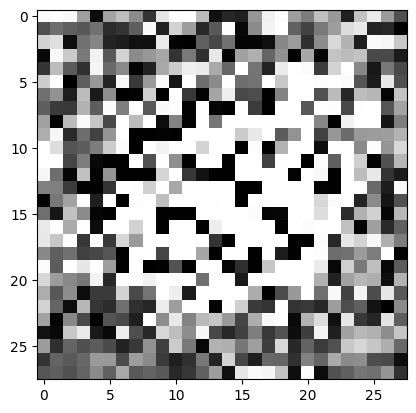

Classifier accuracy 1.0
GAN Epoch: 144
Generator epochs:  1000


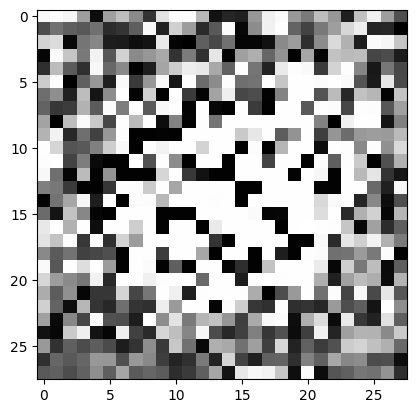

Classifier accuracy 1.0
GAN Epoch: 145
Generator epochs:  1000


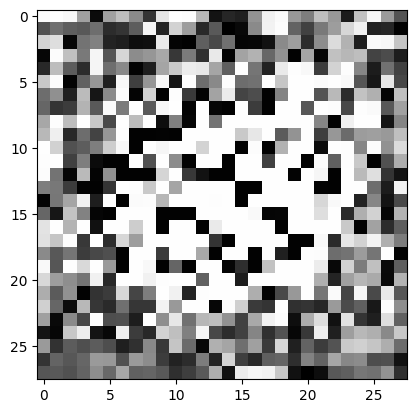

Classifier accuracy 1.0
GAN Epoch: 146
Generator epochs:  1000


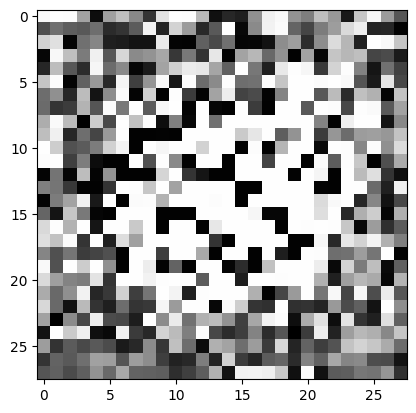

Classifier accuracy 1.0
GAN Epoch: 147
Generator epochs:  1000


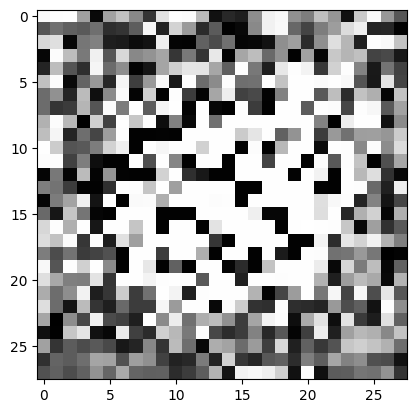

Classifier accuracy 1.0
GAN Epoch: 148
Generator epochs:  1000


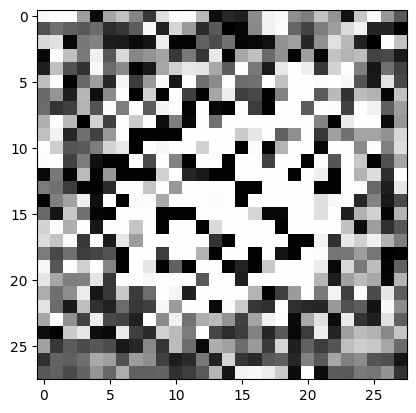

Classifier accuracy 1.0
GAN Epoch: 149
Generator epochs:  1000


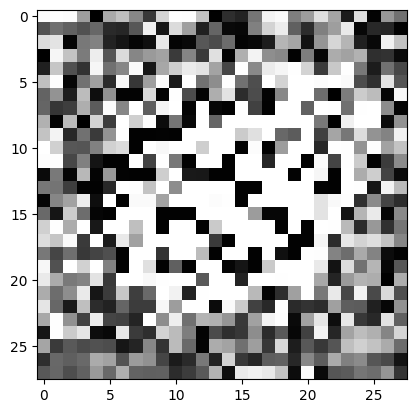

Classifier accuracy 1.0


In [11]:
batch_size = 8000

classifier = Classifier().to(DEVICE)
opt_classifier = optim.Adadelta(classifier.parameters(), lr=CLASSIFIER_LR)

gen = Generator(input_dim=GEN_INPUT_DIM).to(DEVICE)
opt_generator = optim.SGD(gen.parameters(), lr=GEN_LR, momentum=GEN_MOMENTUM)

for e in range(GAN_EPOCH):
  print('GAN Epoch:', e)
  # Toma aleatoria del set real
  true_batch = np.random.randint(0, x_true.shape[0], batch_size)
  x_false_batch = torch.randn(x_true.shape[0], GEN_INPUT_DIM).to(DEVICE)
  # Entrenamos el generador
  train_generator(opt = opt_generator, generator = gen, classifier = classifier, accuracy = 1, plot = False, max_iter=1e3)
  # Entrenamos el clasificador
  x_false = gen(x_false_batch).reshape((x_false_batch.shape[0], 1, 28, 28))
  img = x_false[np.random.randint(0, x_false.shape[0])]
  plot_image( img.cpu(), True, FILE_PATH + 'epoch_{}.png'.format(e))
  train_classifier(opt=opt_classifier, model=classifier, x_true = x_true[true_batch].to(device=DEVICE), x_false = x_false.detach(), accuracy = 1, max_iter= 300, plot = False)